In [1]:
SUBMIT_TO_COMPETITION = True #Don't forget to turn on the GPU for submissions
FIT_ON_PREPROCESSED = True #Has no effect if submitting
MODELS_PATH = '/kaggle/input/ariel25_exp_86/scikitlearn/default/1/Exp_86'

In [2]:
import sys
print(sys.version)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [3]:
#!pip install /kaggle/input/batman-package-for-python-3-11/batman_package-2.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl    #For 2025 kaggle env
!pip install /kaggle/input/batman-package-for-python-3-10/batman_package-2.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl  #For 2024 kaggle env
import batman

Processing /kaggle/input/batman-package-for-python-3-10/batman_package-2.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [4]:
import os
import time
import pandas as pd
import numpy as np
import math
import itertools
import random
from tqdm import tqdm
import multiprocessing as mp
from joblib import Parallel, delayed
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import torch
import torch.nn.functional as F
import scipy.stats
import joblib
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
if SUBMIT_TO_COMPETITION:
    FIT_ON_PREPROCESSED = False
    GET_METRICS = False
    TRAIN_NEW_MODELS = False
else:
    GET_METRICS = True
    TRAIN_NEW_MODELS = True

FIT_PCA = False
ERROR_PCA = True
FOLDS = 10
INNER_FOLDS = 5
EARLY_STOPPING = False
ROOT = "/kaggle"
MASK_HOT_PIXELS = False
SIGNAL_VERSION = 'signal_v5'
MIX_SPLITS = False  # Throw 75% of the val split from inner folds back into the fit training split data.  At risk of data leakage between fitting and error models.

if MASK_HOT_PIXELS:
    SIGNAL_PATH = '/kaggle/input/ariel-updated-signal/signal_v4.npy' if FIT_ON_PREPROCESSED else None
else:
    SIGNAL_PATH = '/kaggle/input/ariel25-signal-v5/signal_v5.npy' if FIT_ON_PREPROCESSED else None

FIT_FEATURES = (['polypoints_std', 'polypoints_range', 'transit_fit_a', 'bat_correction']
                + ['Rs', 'Ms', 'Ts', 'Mp', 'P', 'sma', 'cos_i', 'm_ratio'] 
                + ['half_delta', 'asymmetry', 'transit_half_delta_height']
                + ["transit_residual_std", "rel_noise", "aspect", 'mean_first_diff', 'mean_second_diff']
                + ['a', 'b', 'c',  'impact', 'fgs_diff',  'darkening_correction']  #'x_centre'
                + ["main_wl_bin", "main_mean_diff", "local_diff_2", "local_diff_4", "local_diff_6"]
                + ["local_diff_8", "transit_delta",  "transit_delta_width", 'transit_ratio', 'max_slope']
                )

LGBM_LOCAL_ERROR_FEATURES =  (["main_mean_diff", "local_diff_2", "local_diff_4", "main_wl_bin"]
                              + ["local_diff_6", "local_diff_8"])

ERROR_FEATURES = (['polypoints_range', 'polypoints_std',  'mean_first_diff', 'bat_correction']
                   + ['mean_second_diff', 'asymmetry']
                   +['max_slope', 'c', 'x_centre',  "aspect", 'transit_width', 'rel_noise']
                 )

LGBM_FIT_PARAMETERS = {
                        'num_leaves':12, #got slight drop in score with 14
                        'min_child_samples':15,  #current best score 0.494 was with 15
                        #'colsample_bytree': 0.9,
                        #'reg_alpha': 0.001,
                        #'reg_lambda': 0.01,
                        'objective': 'regression_l2',
                        'learning_rate': 0.01,
                        'max_depth': 6,
                        'n_estimators': 4000,  #Using early stopping: 8000
                        #'tree_learner': 'serial',
                        'verbose' : -1
                      }

LGBM_ERROR_PARAMETERS = {
                        'num_leaves': 5,  #was 5   score drops for 4 and 6
                        'min_child_samples':10,
                        #"colsample_bytree": 0.9,
                        #'reg_alpha': 0.01,
                        #'reg_lambda': 0.1,
                        'objective': 'regression_l2',
                        'learning_rate': 0.01,
                        'max_depth': 4,    #6
                        'n_estimators': 800, #8000,  #Using early stopping
                        #'tree_learner': 'serial',
                        'verbose' : -1
                        }

EXCLUDE_PLANETS = [1843015807]  #exclude from model building and evaluation ids
USE_INTERPOLATED_FIT_THRESHOLD = 0.001 #above this all wavelengths use the fitted value
PCA_FEATURES = 6
PCA_ERROR_FEATURES = 4
NO_BREAKPOINTS_ERROR_FACTOR = 2 #Multiplies the error prediction by this if no breakpoints found (only four examples of this in data)
WL_BINS = 12 #12 current best  16 #18 #20 #24 
BINNING_KERNEL = 25 #41 #19 #25 #19 #15   Want binning_kernel x WL_bins to be >= 283
CONV_KERNEL_LIMITS = {'min':21, 'max': 21} #current best 21, 21  Min/Max concept is flawed.  change to 19 or 25 doesn't make any difference.
#It would only make sense if the samples were differeing in wavelength-frequency
WL_BUFFER = 5  #Number of wavelengths between last model prediction and the end
MODEL_FOLD_VAR_ENSEMBLE_WEIGHTS = 0.5  #between 0 and 1.  Weights the relative importance of modelled variance vs the fold variance
#6.  0.486 weight 0.5,  EF 1.2    applying over 0.0005  ERROR_OFFSET 0.00003  
#5.  0.481 weight 0.25, EF 1      applying over 0.0005
#4.  0.491 weight 0.25, EF 1.25   applying over 0.0005
#3.  0.491 weight 1.0   EF 1.25   all
#2.  0.44  weight 0.5   EF 1.25   all
#1.  0.41  weight 0.25  EF 1.25   all

#current theory,  model is more accurate < 0.0005.  Above that we want a higher blend of fold var.  
#however there are no actual samples in the public test set > 0.0005 anyway, but there could be in the hidden data

ERROR_FACTOR = 1.25 #Allows for slightly worse performance on compeition data?
ERROR_OFFSET = 0
AIRS_MIN_SIGMA, AIRS_MAX_SIGMA = 0.0001, 0.1  #Public notebooks are using 0008 & 0009
WEIGHTED_ENSEMBLE_THRESHOLD = 0.0007  #Above this we include error estimated from fold variance
AIRS_MAX_SHIFT = 0.05  #So high it's just to prevent infinty or other crazyness
FGS_MAX_SHIFT = 0.05
SCALE = 1  #Fudge factor

TRANSITION_BUFFER = 15
MAX_LEFT_EDGE = 20   
MAX_RIGHT_EDGE = 40
TOP_POINTS = 10

In [6]:
TIME_BINS = 15  #15  was used up until version 97
sensor_sizes_dict = {
    "AIRS-CH0": [[11250, 32, 356], [32, 356]],
    "FGS1": [[135000, 32, 32], [32, 32]],
    "cl": 8,
    "cr": 24
    }  # input, mask

# 16 center pixels, rest is just noise
cl = 8
cr = 24

## Filepaths

In [7]:
class Paths():
    def __init__(self,
                 root,
                 train_models,
                 saved_models_path=None,
                 new_signal_name=None,
                 saved_signal_path=None,
                 ):
        _root = Path(root)
        self.working = _root / 'working'
        self.data = _root / 'input/ariel-data-challenge-2025'
        self.test_dir = self.data / 'test'
        self.train_dir = self.data / 'train'
        self.wavelengths = self.data / 'wavelengths.csv'
        self.train_csv = self.data / 'train.csv'
        
        if train_models:
            self.pred_models = self.working / 'prediction_models'
            self.error_models = self.working / 'uncertainty_models'
            self.fit_pipeline = self.working / 'fit_pipeline.pkl'
            self.error_pipeline = self.working / 'error_pipeline.pkl'
            self.pred_models.mkdir(exist_ok=True)
            self.error_models.mkdir(exist_ok=True)
            self.star_info = self.data / 'train_star_info.csv' 
            self.signal_folder = self.train_dir 
        else:
            _models_dir = Path(saved_models_path)
            print(f'Using models from {saved_models_path}')
            self.pred_models = _models_dir / 'prediction_models'
            self.error_models = _models_dir / 'uncertainty_models'
            self.fit_pipeline = _models_dir / 'fit_pipeline.pkl'
            self.error_pipeline = _models_dir / 'error_pipeline.pkl'
            self.star_info = self.data / 'test_star_info.csv' 
            self.signal_folder = self.test_dir

        if saved_signal_path is not None:
            self.signal_path = saved_signal_path
        else:
            self.signal_path = self.working / f'{new_signal_name}.npy'

## Main Processing Classes
### Preprocess

In [8]:
class PreProcessor():
    def __init__(self,
                 signal_version: str,
                 time_bins: int,
                 sensor_sizes: dict,
                 signal_source_dir,
                 mask_hot=True,
                 ):

        self.signal_version = signal_version
        self.time_bins = time_bins
        self.sensor_sizes = sensor_sizes
        self.raw_signal_dir = signal_source_dir
        self.mask_hot = mask_hot

    
    def get_gain_offset(self):
        """
        Get the gain and offset for a given planet and sensor
    
        Unlike last year's challenge, all planets use the same adc_info.
        We can just hard code it.
        """
        gain = 0.4369
        offset = -1000.0
        return gain, offset
    
    
    def read_data(self, planet_id, sensor, folder):
        """
        Read the data for a given planet and sensor
        """
        # get all noise correction frames and signal
        signal = pd.read_parquet(
            folder / f"{planet_id}/{sensor}_signal_0.parquet",
            engine="pyarrow",
        )
        dark_frame = pd.read_parquet(
            folder / f"{planet_id}/{sensor}_calibration_0/dark.parquet",
            engine="pyarrow",
        )
        dead_frame = pd.read_parquet(
             folder / f"{planet_id}/{sensor}_calibration_0/dead.parquet",
            engine="pyarrow",
        )
        linear_corr_frame = pd.read_parquet(
             folder / f"{planet_id}/{sensor}_calibration_0/linear_corr.parquet",
            engine="pyarrow",
        )
        flat_frame = pd.read_parquet(
            folder / f"{planet_id}/{sensor}_calibration_0/flat.parquet",
            engine="pyarrow",
        )

        signal = signal.values.astype(np.float64).reshape(self.sensor_sizes[sensor][0])[
            :, cl:cr, :
        ]
        dark_frame = dark_frame.values.astype(np.float64).reshape(
            self.sensor_sizes[sensor][1]
        )[cl:cr, :]
        dead_frame = dead_frame.values.reshape(self.sensor_sizes[sensor][1])[cl:cr, :]
        flat_frame = flat_frame.values.astype(np.float64).reshape(
            self.sensor_sizes[sensor][1]
        )[cl:cr, :]
        linear_corr = linear_corr_frame.values.astype(np.float64).reshape(
            [6] + self.sensor_sizes[sensor][1]
        )[:, self.sensor_sizes['cl']:self.sensor_sizes['cr'], :]
    
        return (
            signal,
            dark_frame,
            dead_frame,
            linear_corr,
            flat_frame,
        )
    
    
    def ADC_convert(self, signal, gain, offset):
        """
        Step 1: Analog-to-Digital Conversion (ADC) correction
    
        The Analog-to-Digital Conversion (adc) is performed by the detector to convert the
        pixel voltage into an integer number. We revert this operation by using the gain
        and offset for the calibration files 'train_adc_info.csv'.
        """
    
        return signal / gain + offset
    
    
    def mask_hot_dead(self, signal, dead, dark):
        """
        Step 2: Mask hot/dead pixel
    
        The dead pixels map is a map of the pixels that do not respond to light and, thus,
        can't be accounted for any calculation. In all these frames the dead pixels are
        masked using python masked arrays. The bad pixels are thus masked but left
        uncorrected. Some methods can be used to correct bad-pixels but this task,
        if needed, is left to the participants.
        """
    
        hot = sigma_clip(dark, sigma=5, maxiters=5).mask
        hot = np.tile(hot, (signal.shape[0], 1, 1))
        dead = np.tile(dead, (signal.shape[0], 1, 1))
    
        # Set values to np.nan where dead or hot pixels are found
        signal[dead] = np.nan
        if self.mask_hot:
            signal[hot] = np.nan
        return signal
    
    
    def apply_linear_corr(self, c, signal):
        """
        Step 3: linearity Correction
    
        The non-linearity of the pixels' response can be explained as capacitive leakage
        on the readout electronics of each pixel during the integration time. The number
        of electrons in the well is proportional to the number of photons that hit the
        pixel, with a quantum efficiency coefficient. However, the response of the pixel
        is not linear with the number of electrons in the well. This effect can be
        described by a polynomial function of the number of electrons actually in the well.
        The data is provided with calibration files linear_corr.parquet that are the
        coefficients of the inverse polynomial function and can be used to correct this
        non-linearity effect.
        Using horner's method to evaluate the polynomial
        """
        assert c.shape[0] == 6  # Ensure the polynomial is of degree 5
    
        return (
            (((c[5] * signal + c[4]) * signal + c[3]) * signal + c[2]) * signal + c[1]
        ) * signal + c[0]
    
    
    def clean_dark(self, signal, dark, dt):
        """
        Step 4: dark current subtraction
    
        The data provided include calibration for dark current estimation, which can be
        used to pre-process the observations. Dark current represents a constant signal
        that accumulates in each pixel during the integration time, independent of the
        incoming light. To obtain the corrected image, the following conventional approach
        is applied: The data provided include calibration files such as dark frames or
        dead pixels' maps. They can be used to pre-process the observations. The dark frame
        is a map of the detector response to a very short exposure time, to correct for the
        dark current of the detector.
    
        image - (dark * dt)
    
        The corrected image is conventionally obtained via the following: where the dark
        current map is first corrected for the dead pixel.
        """
    
        dark = torch.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark * dt[:, None, None]
        return signal
    
    
    def get_cds(self, signal):
        """
        Step 5: Get Correlated Double Sampling (CDS)
    
        The science frames are alternating between the start of the exposure and the end of
        the exposure. The lecture scheme is a ramp with a double sampling, called
        Correlated Double Sampling (CDS), the detector is read twice, once at the start
        of the exposure and once at the end of the exposure. The final CDS is the
        difference (End of exposure) - (Start of exposure).
        """
    
        return torch.subtract(signal[1::2, :, :], signal[::2, :, :])
    
    
    def bin_obs(self, signal, binning):
        """
        Step 5.1: Bin Observations
    
        The data provided are binned in the time dimension. The binning is performed by
        summing the signal over the time dimension.
        """
    
        # Pad if signal.shape[0] is not divisible by binning
        remainder = signal.shape[0] % binning
        if remainder != 0:
            pad_len = binning - remainder
            pad = signal[-1:].repeat(pad_len, 1, 1)
            signal = torch.cat([signal, pad], dim=0)
    
        # Allocate output tensor on the same device as input
        device = signal.device
        cds_binned = torch.zeros(
            (
                signal.shape[0] // binning,
                signal.shape[1],
                signal.shape[2],
            ),
            device=device,
        )
    
        for i in range(signal.shape[0] // binning):
            cds_binned[i, :, :] = torch.sum(
                signal[i * binning : (i + 1) * binning, :, :], axis=0
            )
    
        return cds_binned


    
    def correct_flat_field(self, flat, signal):
        """
        Step 6: Flat Field Correction
    
        The flat field is a map of the detector response to uniform illumination, to
        correct for the pixel-to-pixel variations of the detector, for example the
        different quantum efficiencies of each pixel.
        """
    
        return signal / flat
    
    
    def nan_interpolation(self, tensor):
        # Assume tensor is of shape (batch, height, width)
        nan_mask = torch.isnan(tensor)
    
        # Replace NaNs with zero temporarily
        tensor_filled = torch.where(
            nan_mask, torch.tensor(0.0, device=tensor.device), tensor
        )
    
        # Create a binary mask (0 where NaNs were and 1 elsewhere)
        ones = torch.ones_like(tensor, device=tensor.device)
        weight = torch.where(nan_mask, torch.tensor(0.0, device=tensor.device), ones)
    
        # Perform interpolation by convolving with a kernel
        # using bilinear interpolation
        kernel = torch.ones(1, 1, 1, 3, device=tensor.device, dtype=tensor.dtype)
    
        # Apply padding to the tensor and weight to prevent boundary issues
        tensor_padded = F.pad(
            tensor_filled.unsqueeze(1), (1, 1, 0, 0), mode="replicate"
        ).squeeze(1)
        weight_padded = F.pad(weight.unsqueeze(1), (1, 1, 0, 0), mode="replicate").squeeze(
            1
        )
    
        # Convolve the filled tensor and the weight mask
        tensor_conv = F.conv2d(tensor_padded.unsqueeze(1), kernel, stride=1)
        weight_conv = F.conv2d(weight_padded.unsqueeze(1), kernel, stride=1)
    
        # Compute interpolated values (normalized by weights)
        interpolated_tensor = tensor_conv / weight_conv
    
        # Apply the interpolated values only to the positions of NaNs
        result = torch.where(nan_mask, interpolated_tensor.squeeze(1), tensor)
    
        return result


    def process_planet(self, planet_id, mask_hot=True):
        """
        Process a single planet's data
        """
    
        axis_info = pd.read_parquet(self.raw_signal_dir.parent / "axis_info.parquet")
        dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values
    
        for sensor in ["FGS1", "AIRS-CH0"]:
            # load all data for this planet and sensor
            signal, dark_frame, dead_frame, linear_corr, flat_frame = self.read_data(
                planet_id, sensor, self.raw_signal_dir
            )
            gain, offset = self.get_gain_offset()
    
            # Step 1: ADC correction
            signal = self.ADC_convert(signal, gain, offset)
    
            # Step 2: Mask hot/dead pixel
            signal = self.mask_hot_dead(signal, dead_frame, dark_frame)
    
            # clip at 0
            signal = signal.clip(0)
    
            # Step 3: linearity Correction
            signal = self.apply_linear_corr(
                torch.tensor(linear_corr).to("cuda:0"), torch.tensor(signal).to("cuda:0")
            )
    
            # Step 4: dark current subtraction
            if sensor == "FGS1":
                dt = torch.ones(len(signal), device="cuda:0") * 0.1
                dt[1::2] += 4.5
            elif sensor == "AIRS-CH0":
                dt = torch.tensor(dt_airs).to("cuda:0")
                dt[1::2] += 0.1
    
            signal = self.clean_dark(signal, torch.tensor(dark_frame).to("cuda:0"), dt)
    
            # Step 5: Get Correlated Double Sampling (CDS)
            signal = self.get_cds(signal)
    
            # Step 5.1: Bin Observations
            if sensor == "FGS1":
                signal = self.bin_obs(signal, binning=self.time_bins * 12)
            elif sensor == "AIRS-CH0":
                signal = self.bin_obs(signal, binning=self.time_bins)
    
            # Step 6: Flat Field Correction
            signal = self.correct_flat_field(torch.tensor(flat_frame).to("cuda:0"), signal)
    
            # Step 7: Interpolate NaNs (twice!)
            signal = self.nan_interpolation(signal)
            signal = self.nan_interpolation(signal)
    
            # Step 8: Sum over spatial axis
            if sensor == "FGS1":
                signal = torch.nanmean(signal, axis=[1, 2]).cpu().numpy()
            elif sensor == "AIRS-CH0":
                signal = torch.nanmean(signal, axis=1).cpu().numpy()
    
            # save the processed signal
            np.save(
                f"{planet_id}_{sensor}_signal_{self.signal_version}.npz",
                signal.astype(np.float64),
            )


### Mid Process

In [9]:
class MidProcessor():
    def __init__(self,
                 wavelengths,
                 wl_bins: int = WL_BINS,
                 binning_kernel: int = BINNING_KERNEL,
                 conv_kernel_limits: dict = CONV_KERNEL_LIMITS,
                 edge_buffer: int = WL_BUFFER,
                 ):

        self.wavelengths = wavelengths # pd.read_csv(paths.wavelengths)
        self.wl_bins = wl_bins
        self.binning_kernel = binning_kernel
        self.min_conv_kernel = conv_kernel_limits['min']
        self.max_conv_kernel = conv_kernel_limits['max']
        self.edge_buffer = edge_buffer        
    

    def sigma_clip_3d(self, data, window_size=10, sigma=5, use_window_mean=False, mean_window=5):
        """Performs sigma clip across dimension 3 in a 3d tensor"""
        assert data.ndim == 3, "Input must be a 3D array"
        if window_size % 2 == 0:
            window_size += 1
        if mean_window % 2 == 0:
            mean_window += 1
    
        N, T, F = data.shape
    
        # Apply median filter along axis=1 (time)
        local_median = np.apply_along_axis(
            lambda x: medfilt(x, kernel_size=window_size),
            axis=1,
            arr=data
        )
    
        residual = data - local_median
        mad = np.median(np.abs(residual), axis=1, keepdims=True)
        robust_std = mad * 1.4826
        outliers = np.abs(residual) > (sigma * robust_std)
    
        clean_data = data.copy()
    
        for i in range(N):
            for j in range(F):
                outlier_idxs = np.where(outliers[i, :, j])[0]
                for t in outlier_idxs:
                    if use_window_mean:
                        # Use local mean within a window
                        half_w = mean_window // 2
                        t_start = max(0, t - half_w)
                        t_end = min(T, t + half_w + 1)
                        local_vals = clean_data[i, t_start:t_end, j]
                        valid_vals = local_vals[~outliers[i, t_start:t_end, j]]
                        if valid_vals.size > 0:
                            clean_data[i, t, j] = valid_vals.mean()
                        else:
                            fallback = np.median(clean_data[i, :, j][~outliers[i, :, j]])
                            clean_data[i, t, j] = fallback
                    else:
                        # Interpolate from adjacent points
                        prev_idx = t - 1
                        next_idx = t + 1
                        prev_val = clean_data[i, prev_idx, j] if prev_idx >= 0 and not outliers[i, prev_idx, j] else np.nan
                        next_val = clean_data[i, next_idx, j] if next_idx < T and not outliers[i, next_idx, j] else np.nan
    
                        if not np.isnan(prev_val) and not np.isnan(next_val):
                            clean_data[i, t, j] = 0.5 * (prev_val + next_val)
                        elif not np.isnan(prev_val):
                            clean_data[i, t, j] = prev_val
                        elif not np.isnan(next_val):
                            clean_data[i, t, j] = next_val
                        else:
                            fallback = np.median(clean_data[i, :, j][~outliers[i, :, j]])
                            clean_data[i, t, j] = fallback

        return clean_data #, outliers

    

    def bin_wavelengths_skip_first(self, data, method='mean'):
        if data.ndim != 3:
            raise ValueError("Input must be a 3D array (star, time, wavelength)")
    
        N, T, W = data.shape
        head = data[:, :, :1]  # Preserve first index (shape N, T, 1)
        tail = data[:, :, 1:]  # Wavelengths from index 1 onward (shape N, T, W-1)
    
        tail_len = tail.shape[-1]
        step_size = (tail_len-2*self.edge_buffer) / (self.wl_bins-1)
        half_kernel = self.binning_kernel // 2
        centres = [int(self.edge_buffer + (n + 1) * step_size) for n in range(self.wl_bins-2)]
    
        binned_list = []
    
        first_chunk = tail[:, :, :self.edge_buffer + half_kernel].mean(axis=-1, keepdims=True)
        last_chunk = tail[:, :, -half_kernel-self.edge_buffer:].mean(axis=-1, keepdims=True)
    
        binned_list = [first_chunk]
        for centre in centres:
            start = max(0, centre - half_kernel)
            end = min(tail_len, centre + half_kernel)
            chunk = tail[:, :, start:end]  # shape (N, T, kernel_size)
            binned_chunk = chunk.mean(axis=-1, keepdims=True)
            binned_list.append(binned_chunk)  # shape (N, T, 1)
        binned_list.append(last_chunk)
        tail_binned = np.concatenate(binned_list, axis=-1)  # shape (N, T, wl_bins)
        binned_data = np.concatenate([head, tail_binned], axis=2)  # shape (N, T, 1 + wl_bins)
    
        return binned_data, [self.edge_buffer] + centres + [W-1-self.edge_buffer]


    def convolve_wavelengths_skip_first(self, differences, n_jobs=1):
        head = self.full_signal[:, :, :1]   # keep the first wavelength
        tail = self.full_signal[:, :, 1:]   # convolve over the rest
        N, T, tail_len = tail.shape
    
        if differences is None:
            mean_kernel = self.max_conv_kernel
            kernels = [mean_kernel] * N
        else:
            slope = (self.max_conv_kernel - self.min_conv_kernel)/self.max_conv_kernel
            kernels = [self.min_conv_kernel + slope * (1-norm_diff) for norm_diff in differences]
    
        def gaussian_weights(size, sigma=None):
            """Generate normalized Gaussian weights of given size."""
            if sigma is None:
                sigma = size / 6  # rule of thumb so ~99% falls inside kernel
            center = size // 2
            x = np.arange(size)
            w = np.exp(-0.5 * ((x - center) / sigma) ** 2)
            return w / w.sum()
    
        def process_array(n):
            kernel_size = int(kernels[n])
            half_kernel = kernel_size // 2
            weights = gaussian_weights(kernel_size)
    
            binned_list = []
            for idx in range(tail_len):
                start = max(0, idx - half_kernel)
                end = min(tail_len, idx + half_kernel + 1)
    
                # adjust weights for edge cases
                w = weights[(half_kernel - (idx-start)):(half_kernel + (end-idx))]
                w = w / w.sum()  # re-normalize so it sums to 1
    
                chunk = tail[n, :, start:end]   # (T, variable_size)
                binned_list.append((chunk * w).sum(axis=-1, keepdims=True))  # weighted sum
    
            return np.concatenate(binned_list, axis=-1)  # (T, tail_len)
    
        convolved_list = [process_array(n) for n in range(N)]
        tail_binned = np.stack(convolved_list, axis=0)   # (N, T, tail_len)
    
        return np.concatenate([head, tail_binned], axis=2)  # (N, T, 1+tail_len)

    def process_signal(self, signal_path):
        full_signal = np.load(signal_path)
        full_signal = self.sigma_clip_3d(full_signal, window_size=9, sigma=7, use_window_mean=True, mean_window=5)
        if np.isnan(full_signal).any() or np.isinf(full_signal).any():
            print("Array contains NaN or Inf values")
    
        cut_inf, cut_sup = 36, 318
        self.full_signal = np.concatenate(
            [full_signal[:, :, 0][:, :, None], full_signal[:, :, cut_inf:cut_sup]], axis=2
        )
        
        binned_signal, centres = self.bin_wavelengths_skip_first(self.full_signal, method='mean')
        return binned_signal, centres

## Helpers Functions

In [10]:
def format_submission(pred_array,
                   index,
                   sigma_df):

    sigma_cols = [f'sigma_{i+1}' for i in range(283)]
    expanded_cols = pd.concat([sigma_df.iloc[:, [1]]] * 282, axis=1)
    sigma_expanded = pd.concat([sigma_df.iloc[:, 0], expanded_cols], axis=1)
    sigma_expanded.columns = sigma_cols
    
    if pred_array.shape[1] == 1:
        pred_array = np.repeat(pred_array, 283, axis=1)

    preds_df = pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns)

    formatted = pd.concat([preds_df, sigma_expanded], axis=1)

    return formatted


class ParticipantVisibleError(Exception):
    pass


def competition_score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    naive_mean: float,
    naive_sigma: float,
    sigma_true: float = 0.00001,
    row_id_column_name: str = "planet_id",
) -> float:
    """
    This is a Gaussian Log Likelihood based metric. For a submission, which contains
    the predicted mean (x_hat) and variance (x_hat_std), we calculate the Gaussian
    Log-likelihood (GLL) value to the provided ground truth(x). We treat each pair
    of x_hat, x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian
    distributions, hence 283 values for each test spectrum, the GLL value for one
    spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    """

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError("Negative values in the submission")
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f"Submission column {col} must be a number")

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths * 2:
        raise ParticipantVisibleError("Wrong number of columns in the submission")

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(
        submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None
    )
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(
        scipy.stats.norm.logpdf(
            y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)
        )
    )
    GLL_mean = np.sum(
        scipy.stats.norm.logpdf(
            y_true,
            loc=naive_mean * np.ones_like(y_true),
            scale=naive_sigma * np.ones_like(y_true),
        )
    )

    submit_score = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))


def sigma_clip_1d(data, window_size=3, sigma=3):
    """
    Flags local spikes: compare each point to local median, but use global std to define outliers.
    
    Parameters:
        data (np.ndarray): 1D array of values.
        window_size (int): Size of the window for local median.
        sigma (float): Threshold multiplier for global robust std.
        
    Returns:
        clean_data (np.ndarray): Copy of data with local outliers replaced by NaN.
        outliers (np.ndarray): Boolean mask of outlier positions.
    """
    # Local median (or use uniform_filter1d for mean)
    local_baseline = medfilt(data, kernel_size=window_size)

    # Global robust std using MAD
    global_residual = data - np.median(data)
    mad = np.median(np.abs(global_residual))
    robust_std = mad * 1.4826

    # Detect outliers based on local deviation but global threshold
    residual = data - local_baseline
    outliers = np.abs(residual) > (sigma * robust_std)

    # Replace outliers with NaN
    clean_data = data.copy()

    for i in np.where(outliers)[0]:
        if 0 < i < len(data) - 1:
            clean_data[i] = 0.5 * (data[i - 1] + data[i + 1])
        elif i == 0:
            clean_data[i] = data[i + 1]
        elif i == len(data) - 1:
            clean_data[i] = data[i - 1]

    return clean_data #, outliers


def interpolate_predictions(bin_values, pred_indices, output_length=282, kind='cubic'):
    """
    Interpolates 12-point predictions to a full 282-length array using cubic spline.

    Parameters:
    - predicted_values: np.ndarray of shape (N, 12)
    - pred_indices: array-like of shape (12,) with indices of the predicted values (must be increasing)
    - output_length: int, length of the final interpolated array (default=282)
    - kind: interpolation type, e.g., 'linear', 'cubic', 'quadratic'

    Returns:
    - interpolated: np.ndarray of shape (N, output_length)
    """

    pred_indices = [0] + pred_indices + [output_length]

    first_col = bin_values[:, [0]]
    last_col = bin_values[:, [-1]]
    extended = np.hstack([first_col, bin_values, last_col])
    
    N, num_preds = extended.shape
    if len(pred_indices) != num_preds:
        raise ValueError("Number of pred_indices must match number of columns in predicted_values.")

    x_full = np.arange(output_length)
    interpolated = np.empty((N, output_length))

    for i in range(N):
        #clipped = sigma_clip_1d(extended[i], window_size = 3, sigma = 2)  #remove local spikes
        #interp_func = interp1d(pred_indices, clipped, kind=kind, fill_value="extrapolate")  #extended[i]
        interp_func = interp1d(pred_indices, extended[i], kind=kind, fill_value="extrapolate")  #extended[i]
        interpolated[i] = interp_func(x_full)

    return interpolated

### Offset Quadratic Fitting

In the baseline regions:
$$
y = b x + c
$$

In the transition regions: 
$$
y = a(x - x_0)^2 + b x + c + \delta
$$

The key goal here is to fit b, then use it later to adjust the signal for any linear drift

In [11]:
def edge_detector(data,
                  breakpoints,
                  verbose=True,
                  ):
                   #fallback_width=60):
    '''This is to work with an existing breakpoint, to detect the edge of the ingress/egress 
    for a single planet in the vacinity of the breakpoint'''
    

    left_corner, right_corner = 0, len(data)  #Initialise in case of no BP available

    def plot_result(y, second_derivative, corner_idx):
        fig, ax1 = plt.subplots()
    
        ax1.plot(y, color="grey", alpha=0.5, label="original")
        ax1.set_ylabel("Original signal", color="grey")
    
        ax2 = ax1.twinx()
        ax2.plot(second_derivative, color="green", alpha=0.9, label="second derivative")
        ax2.set_ylabel("Second derivative", color="green")
    
        ax1.axvline(corner_idx, color="r")
        plt.title("Signal and second derivative")
        plt.show()

    def find_corner(y, verbose):
        first_derivative = np.gradient(y)
        second_derivative = np.gradient(first_derivative)
        corner_idx = np.argmin(second_derivative)
        if verbose:
            plot_result(y, second_derivative, corner_idx)
        return corner_idx
    
    left_bp = breakpoints[0]
    right_bp = breakpoints[1]
    if left_bp is not None and left_bp >= 10: 
        start = max([0, left_bp-40])
        left_data = data[start:left_bp]
        left_corner = find_corner(left_data, verbose=verbose) + start
        #left_corner = int(np.max([left_corner, left_bp - 40]))  #redundant
        
    if right_bp is not None and right_bp < len(data) - 10:
        stop = min([right_bp  + 40, len(data)])
        right_data = data[right_bp: stop]
        right_corner = find_corner(right_data, verbose=verbose)
        #right_corner = int(np.min([right_corner, 40]))  #redundant
        right_corner = right_bp + right_corner #make relative to the breakpoint

    if verbose:
        print(f'The left corner is {left_corner} right is {right_corner}')

    return left_corner, right_corner

In [12]:
# find transit zones
def phase_detector(signal_orig,
                   binning_num,
                   buffer = 10,
                   smooth_window=11,
                   verbose=True
                   ):
                   #fallback_width=60):
    
    signal = signal_orig.reshape(-1, binning_num).mean(-1)  # collapse by 15; 375
    signal = savgol_filter(signal, smooth_window, 2)  # smooth
    first_derivative = np.gradient(signal)
    left_bp = np.argmin(first_derivative)
    right_bp = np.argmax(first_derivative)

    left_edge, right_edge = edge_detector(signal,
                                         (left_bp, right_bp),
                                          verbose = verbose 
                                          )

    if verbose:
        plt.plot(signal_orig, color="grey", alpha=0.5, label="original")
        plt.plot(signal, color="blue", alpha=0.9, label="smoothed")
        plt.axvline(left_edge, color="orange")
        plt.axvline(left_bp, color="r")
        plt.axvline(right_bp, color="r")
        plt.axvline(right_edge, color="orange")
        plt.show()
        plt.plot(first_derivative, color="green", alpha=0.9, label="first derivative")
        plt.show()

    full_length = signal.shape[0]
    #first_bit= full_length // 32
    #last_bit = 31 * full_length // 32
    if left_bp >= right_bp:
        print(f'The breakpoints are: {left_pb}, {right_bp} with length {full_length}')
        centre = np.argmin(signal_orig)
        #if not (first_bit < centre < last_bit):
        #    centre = full_length // 2
        #    print('min in the first or last bit')
        #phase1_idx = max(0, centre - fallback_width)
        #phase2_idx = min(signal_orig.shape[0], centre + fallback_width)
        #print(f'The fallbacks are {phase1_idx}, {phase2_idx}, with min at {centre}, centre {full_length//2}')

        plt.plot(signal_orig, color="grey", alpha=0.5, label="original")
        plt.plot(signal, color="blue", alpha=0.9, label="smoothed")
        plt.axvline(left_bp, color="r")
        plt.axvline(right_bp, color="r")
        plt.show()
        plt.plot(first_derivative, color="green", alpha=0.9, label="first derivative")
        plt.show()

    if left_bp is not None and right_bp is not None:
        if left_bp >= right_bp:  #it's no use unless there are actually enough points to fit to
            if left_bp >= full_length // 2:
                left_bp = None
            if right_bp <= full_length // 2:
                right_bp = None
    #So at this point one or both could potentially be None     
    if left_bp is not None and left_bp < buffer + 20:
        left_bp = None
    if right_bp is not None and right_bp > full_length - buffer - 20:
        right_bp = None

    if left_bp is None:
        left_edge = 0
    if right_bp is None:
        right_edge = full_length
        
    return (left_bp, right_bp), (left_edge, right_edge)



def get_breakpoints(x, pre_binned_time, binning_num, buffer = 10, verbose=True):
    breakpoints = []
    edges = []
    for i in range(x.shape[0]):
        verbose = True if i <= 5 else False
        signal = x[i].mean(-1)
        try:
            bps, edge_positions  = phase_detector(signal,
                                                  binning_num = binning_num // pre_binned_time,
                                                  buffer = buffer,
                                                  smooth_window=21,
                                                  verbose=verbose   #was smooth window=19
                                                  )
            #bps = (None, None)                #for troubleshooting only remove later
            #edge_positions = (0, len(signal))
        except:
            bps = (None, None)
            edge_positions = (0, len(signal))
        breakpoints.append(bps)  #either or both could be None
        #print(bps, edge_positions)
        edges.append(edge_positions)

    return breakpoints, edges   #list of tuples, with position corresponding to index of the planet in signal array


def crop_transitions(signal,
                     breakpoints,
                     edges,
                     buffer,
                     plot=False,
                     reflect=None,
                     min_main_width=10,
                     max_edge_widths= (40,40),
                     top_points = 10
                     ):

    no_breakpoints = False
    two_breakpoints = False
    trim_left, trim_right = 0, 0 

    if breakpoints[0] is None and breakpoints[1] is None:
        no_breakpoints = True
        #print('Setting no_breakpoints to True')
    
    if breakpoints[0] is not None and breakpoints[1] is not None:
        two_breakpoints = True

    reflected = False
    N = len(signal)

    left_max = np.max(signal[:100])
    right_max = np.max(signal[-100:])
    reflect_conditions = right_max > left_max  #(right_max > left_max) or (breakpoints[0] is None and breakpoints[1] is not None)
    reflect = reflect if reflect is not None else reflect_conditions

    # Normalize breakpoints input
    bp_left_orig, bp_right_orig = breakpoints

    if reflect:
        reflected = True
        signal = signal[::-1]
        # Correct transformation of both breakpoints after reversing:
        # new_index = (N - 1) - old_index
        left_breakpoint = None if bp_right_orig is None else (N - 1 - int(bp_right_orig))
        right_breakpoint = None if bp_left_orig is None else (N - 1 - int(bp_left_orig))
        left_edge = N - int(edges[1])
        right_edge =  N - int(edges[0])
    else:
        left_breakpoint = None if bp_left_orig is None else int(bp_left_orig)
        right_breakpoint = None if bp_right_orig is None else int(bp_right_orig)
        left_edge, right_edge = edges[0],  edges[1]

    # Buffers: if a breakpoint is missing, add extra margin

    #let's estimate the distance from transit start to and from breakpoint (mid ingress/egress)
    buffers = []
    fallback = buffer
    if left_breakpoint is not None:
        left_internal_buffer = np.max([fallback, left_breakpoint - left_edge])
        buffers.append(left_internal_buffer)
    if right_breakpoint is not None:
        right_internal_buffer = np.max([fallback, right_edge - right_breakpoint])
        buffers.append(right_internal_buffer)
    if buffers:
        buffer = int(np.mean(buffers))

    #print(f'the new buffer is {buffer}')
        
    left_buffer = buffer + 20 if left_breakpoint is None else buffer
    right_buffer = buffer + 20 if right_breakpoint is None else buffer

    # Defaults: use full-range semantics (right_bp is exclusive)
    left_bp = 0 if left_breakpoint is None else left_breakpoint
    right_bp = N if right_breakpoint is None else right_breakpoint

    # Clamp to valid range
    left_bp = max(0, min(left_bp, N))
    right_bp = max(0, min(right_bp, N))

    # Available "main" width after buffers
    available = right_bp - left_bp - left_buffer - right_buffer

    # If nothing fits, try to reduce buffers to salvage the main section if breakpoints exist
    if available <= 0 and (left_breakpoint is not None or right_breakpoint is not None):
        total_span = max(1, right_bp - left_bp)
        # shrink each buffer proportionally but keep them non-negative
        left_buffer = min(left_buffer, max(0, total_span // 4))
        right_buffer = min(right_buffer, max(0, total_span // 4))

    #centre = (left_bp + right_bp) // 2

    x = np.arange(N)

    if no_breakpoints:
        # original "no breakpoints" behavior
        #print('Using the no-breakpoints fallback')
        left_peak_idx = int(np.argmax(signal[: N//2]))
        x0 = x[:left_peak_idx+1]
        skip_start = left_peak_idx + buffer + 25
        # guard against out-of-range slicing
        start = min(skip_start, N)
        stop = max(N - (buffer + 20), start)
        x1 = x[start:stop]
        x2 = np.array([], dtype=int)
        #x_centre = int(np.argmin(signal))

    elif left_breakpoint is None:
        left_peak_idx = int(np.argmax(signal[: N//2]))
        x0 = x[:left_peak_idx+1]
        skip_start = left_peak_idx + buffer + 25
        # guard against out-of-range slicing
        start = min(skip_start, N)
        stop = right_bp - right_buffer
        # ensure at least one element in x1 if possible
        if stop <= start:
            stop = start + 1
            if stop > N:
                stop = N
                start = max(0, stop - 1)
        x1 = np.arange(start, stop)

        # right chunk
        if right_bp < N - 1:
            right_idx = min(right_bp + buffer, N - 5)
            right_idx = max(right_idx, 0)
            x2 = np.arange(right_idx, N) if right_idx < N else np.array([], dtype=int)
        else:
            x2 = np.array([], dtype=int)
    else:
        #For this branch, there is definately a left breakpoint, but there might not be a right one

        if left_edge >=5:
            left_posn = max(5, left_edge)  #want at least 5 points, but not getting too close to the inflection point
            x0 = np.arange(left_posn)
        else:
            x0 = np.array([], dtype=int)

        # main block
        start = left_bp + left_buffer
        stop = right_bp - right_buffer
        # ensure at least one element in x1 if possible
        if stop <= start:
            stop = start + 1
            if stop > N:
                stop = N
                start = max(0, stop - 1)
        x1 = np.arange(start, stop)

        # right chunk.  Want it limited to the edge plus about 20 points, but not greater than the edge of the array
        if right_bp < N - 1:
            right_idx = min(right_edge, N - 5)
            right_idx = max(right_idx, 0)
            x2 = np.arange(right_idx, N) if right_idx < N else np.array([], dtype=int)
        else:
            x2 = np.array([], dtype=int)
    
    original_x0 = len(x0)
    original_x2 = len(x2)
    x0 = x0[-max_edge_widths[0]:]
    x2 = x2[:max_edge_widths[1]]
    trimmed = (original_x0-len(x0), original_x2 - len(x2))
    

    x_idxs = np.concatenate([x0, x1, x2]) if (len(x0) + len(x1) + len(x2)) > 0 else np.array([], dtype=int)

    
    if len(x0) > 0 and len(x2) > 0:  
        # Since we have two breakpoints, we can remove any issues with wandering sensors outside ingress/egress
        y0 = signal[x0]
        top_idx_0 = np.argsort(y0)[-top_points:]    #[-15:]
        x_top_0 = x0[top_idx_0]
        y_top_0 = y0[top_idx_0]
    
        y2 = signal[x2]
        top_idx_2 = np.argsort(y2)[-top_points:]  #  [:15]
        x_top_2 = x2[top_idx_2]
        y_top_2 = y2[top_idx_2]
    
        # Combine points for fitting
        x = np.concatenate([x_top_0, x_top_2])
        y = np.concatenate([y_top_0, y_top_2])
    
        # Fit straight line
        m, b = np.polyfit(x, y, 1)
    
        # Evaluate the fitted line separately for each group
        y0_fit = m * x0 + b
        y1 = signal[x1]   # unchanged
        y2_fit = m * x2 + b
    
        # Concatenate in correct order
        y_final = np.concatenate([y0_fit, y1, y2_fit])
    else:
        y_final = signal[x_idxs] if x_idxs.size else np.array([], dtype=signal.dtype)
        
    left_transition = len(x0)
    right_transition = len(x0) + len(x1)

    x_offset = x0[-1] if len(x0) > 0 else 0

    x_final = x_idxs - x_offset #offset so that 0 occurs around the left transition
    centre = (right_transition + left_transition) // 2 #centre - x_offset


    width = right_transition - left_transition
    part_width = width / 4
    if not left_transition + part_width < centre < right_transition - part_width:
        print(f'There is a problem with crop_transitions.  The final tuple is {(left_transition, centre, right_transition)}')

    return x_final, y_final, (left_transition, centre, right_transition), no_breakpoints, two_breakpoints, reflected, x_offset, trimmed


def shifted_quadratic_model(x, a, b, c, delta, x0, transition_1, transition_2):
    """Piecewise model:
       - y = b*x + c for baseline (outside transition)
       - y = a*(x - x0)^2 + b*x + c + c_offset for transition
    """
    x = np.asarray(x)
    N = len(x)

    baseline_mask = np.zeros(N, dtype=bool)
    baseline_mask[:transition_1] = True
    baseline_mask[transition_2:] = True
    transit_mask = ~baseline_mask

    y_fit = np.zeros(N)
    y_fit[baseline_mask] = b * x[baseline_mask] + c
    y_fit[transit_mask] = a * (x[transit_mask] - x0)**2 + b * x[transit_mask] + c + delta

    return y_fit


def fit_shifted_model(x, y, transitions, edges, plot=False, no_breakpoints=False, initial_fit=None, breakpoints=None, fit_centre=True):
   
    def parameters_are_sensible(popt, transitions):
        #if fixed_x0:
        if len(popt) == 3:
            a, b, delta = popt
        else:
            a, b, delta, centre = popt

        if popt is None or not np.all(np.isfinite(popt)):
            return False
        if np.any(np.abs(popt) > 1e6):
            return False
        if not (-.05 < b < 0.05):
            return False
        if delta > 0.1:
            return False
        part_width = (transitions[2] - transitions[0]) / 6
        if not transitions[0] + part_width < transitions[1] < transitions[2] - part_width:
            print(f'There is a problem with the centre fit, transitions are now {transitions}')
            return False

        
        return True
    
    #print(f'The edges are {edges}')
    #print(f'The transitions are (left, centre, edge) {transitions}')

    transition_0 = transitions[0]
    centre_idx = transitions[1]
    centre_val = x[centre_idx]
    transition_2 = transitions[2]
    x = np.asarray(x)
    y = np.asarray(y)
    
    left_slice = y[:np.max([1,transition_0])]
    right_slice = y[np.min([len(y) - 1, transition_2]):]
    left_mean = np.nanmean(left_slice)
    right_mean = np.nanmean(right_slice)
    #fixed_c = np.max([left_mean, right_mean])  #only used with fixed x0
    fixed_c = left_mean if len(left_slice) >1 else np.nanmax(y[:20])


    if initial_fit is not None:
        p0 = [initial_fit['a'],
              initial_fit['b'],
              #initial_fit['c'],
              initial_fit['delta']]
              #initial_fit['x0']]
    else:
        p0 = [0.0, 0.0, 0.01]  # a, b, delta
      

    def wrapped_model(x, a, b, delta):
        return shifted_quadratic_model(x, a, b, fixed_c, delta,  centre_val, transition_0, transition_2)

    def wrapped_model_fit_centre(x, a, b, delta, centre):
        return shifted_quadratic_model(x, a, b, fixed_c, delta,  centre_val, transition_0, transition_2)

    fallback_factor = 1
    
    try:
        try:
            #improve this with another try-except
            if fit_centre:
                try:
                    popt, pcov = curve_fit(wrapped_model_fit_centre, x, y, p0=p0 + [centre_val], maxfev=5000)
                    a, b, delta, centre_val = popt
                    y_fit = wrapped_model_fit_centre(x, *popt)
                    correction_fit = b*x + fixed_c
                    if not parameters_are_sensible(popt, (x[transition_0], centre_val, x[transition_2 - 1])):
                        plot=True
                        raise ValueError("Unreasonable parameter from the first attempt fitting the centre")
                    #Need to adjust the transitions to get the index that matches this value
                    value_to_index = {val: idx for idx, val in enumerate(x)}
                    centre_idx = value_to_index[int(centre_val)]  
                    transitions = (transition_0, centre_idx, transition_2)  #only over-writing the centre if it passes above test
                except:
                    popt, pcov = curve_fit(wrapped_model, x, y, p0=p0, maxfev=5000)
                    a, b, delta = popt
                    y_fit = wrapped_model(x, *popt)
                    correction_fit = b*x + fixed_c
                    if not parameters_are_sensible(popt, transitions):
                        raise ValueError("Unreasonable parameter values from the fallback, fixing the centre")      
            else:
                popt, pcov = curve_fit(wrapped_model, x, y, p0=p0, maxfev=5000)
                a, b, delta = popt
                y_fit = wrapped_model(x, *popt)
                correction_fit = b*x + fixed_c
                
                if not parameters_are_sensible(popt, transitions):
                    raise ValueError("Unreasonable parameter values without attempting to fit the centre")
            
            if plot:
                print(f'The fit as expected with no_breakpoints = {no_breakpoints}')
                plt.figure(figsize=(10, 5))
                plt.plot(x, y, 'o', alpha=0.5, label='Data')
                plt.plot(x, y_fit, '-', color = 'purple', linewidth=2, label='Fitted curve')
                plt.plot(x, correction_fit, '_', color = 'green', linewidth=2, label='Fitted correction')
                plt.axvline(x[transition_0+1], linestyle='--', color='gray', label='Transition start')
                plt.axvline(x[transition_2-1], linestyle='--', color='gray', label='Transition end')
                #plt.axvline(x[edges[0] - transition_0], linestyle='--', color='green', label='Ingress start')  #not quite got this right yet
                #plt.axvline(edges[1], linestyle='--', color='gray', label='Egress end')
                plt.axvline(x[centre_idx], linestyle=':', color='red', label='x0')
                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend()
                plt.title("Shifted Quadratic Fit with Shared Linear Drift")
                plt.grid(True)
                plt.tight_layout()
                plt.show()
    
        
        except Exception as e:
            fallback_factor = 1   #score dropped slightly with 1.5
            print(f'The error from the first fit attempt was {e}')
            try:
                left_idx = np.max([60, transition_0])
                right_idx = np.min([len(x) - 60, transition_2])
                x_cropped = x[left_idx:right_idx]
                y_cropped = y[left_idx:right_idx]
        
                transit_coeffs = np.polyfit(x_cropped-centre_val, y_cropped, 2)
                transit_poly = np.poly1d(transit_coeffs)
                y_fit = transit_poly(x-centre_val)
                delta = fixed_c - np.min(y_fit)
                a = transit_coeffs[0]
                if len(right_slice) <=1:
                    right_mean = left_mean
                b = (right_mean - left_mean)/(x[-1] - x[0])
                c=fixed_c
                baseline = b * x + c
                
                min_idx = np.argmin(y)
                delta = baseline[min_idx] - y[min_idx]

                y_fit[:60] = b * x[:60] + c
                y_fit[-60:] = b * x[-60:] + c
            
                if plot:
                    print('The fallback fit, because the main fit failed')
                    print(f'first value of x is {x[0]} first val of y is {y[0]}')
                    plt.figure(figsize=(10, 5))
                    plt.plot(x, y, 'o', alpha=0.5, label='Data')
                    plt.plot(x, y_fit, '-', linewidth=2, label='Fitted curve')
                    plt.axvline(x[transition_0+1], linestyle='--', color='gray', label='Transition start')
                    plt.axvline(x[transition_2-1], linestyle='--', color='gray', label='Transition end')
                    plt.axvline(x[centre_idx], linestyle=':', color='red', label='centre')
                    plt.xlabel("x")
                    plt.ylabel("y")
                    plt.legend()
                    plt.title("Fallback fit")
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show() 
            
                    #y_correction = b * x + ccrop_transitions
            except Exception as e2:
                print(f"Second fit failed: {e2}")
        
    except:
        fallback_factor = 1  #score dropped slightly with 1.5
        print('Using the last backup exception')
        a = 0
        b = 0
        delta = np.max(y) - np.min(y)
        y_fit = y

    transit_points = transition_2 - transition_0
    transit_width =  x[transition_2-1] - x[transition_0]
    transit_delta =  (y_fit[transition_0] + y_fit[transition_2-1])/2 - y_fit[centre_idx]
    half_delta = (y_fit[transition_0 + transit_points//2] + y_fit[transition_2-1 - transit_points//2])/2 - y_fit[centre_idx]
    transit_delta_height = transit_delta / delta
    transit_half_delta_height = half_delta / delta
    transit_delta_width = transit_delta / transit_width
    max_slope = a * transit_width / 2

    
    return {
        "a": a,
        "b": b,
        "c": fixed_c,
        "a_c": a / fixed_c,
        "delta": delta,
        "x_centre": centre_val,
        'transit_width': transit_width,
        'transit_delta': transit_delta,
        'half_delta': half_delta,
        "transit_delta_width": transit_delta_width,
        #"transit_delta_height": transit_delta_height,
        'transit_half_delta_height': transit_half_delta_height,
        'max_slope': max_slope,
        'fallback_factor': fallback_factor,
        #"y_fit": y_fit,
        #"params": popt,
        #"covariance": pcov,
        }, (x, y_fit), transitions

def fit_transit(x, y):
    original_length = len(y)
    min_width = 3 * original_length // 4  #Score dropped with 20 Only need to increase this if we would like to use other prameters like 'curvyness'
    final_length = np.min([min_width, original_length])
    to_trim = (original_length - final_length)//2

    if to_trim > 0:
        x = x[to_trim:-to_trim]
        y = y[to_trim:-to_trim]

    try:
        transit_coeffs = np.polyfit(x, y, 2)
        transit_poly = np.poly1d(transit_coeffs)
        transit_fit_y = transit_poly(x)
        [a, b, c] = transit_coeffs
    
        # Transit depth is the minimum of the fitted second polynomial
        transit_depth = 1 - np.min(transit_fit_y)
        residual_std = np.std(transit_fit_y - y)
        relative_size = residual_std / transit_depth  
    except:
        transit_depth = 1-np.min(y)
        residual_std = np.std(1 - y)
        a = 0
        
    # Residuals from second fit
    #baseline_residual_std = np.std(signal_02)
    transit_width = len(x)
    aspect_ratio = transit_depth/(len(x))
    relative_size = residual_std / transit_depth

    return {"transit_width": transit_width,
            "max_wl_depth":  transit_depth,
            "mean_wl_depth": 1 - np.mean(transit_fit_y),
            "transit_residual_std": residual_std,
            "rel_noise": relative_size,
            "aspect": aspect_ratio,
            "transit_fit_a": a,
            }, (x, transit_fit_y)


def correct_k2_old(delta_obs, a, x_ingress, x_egress, b):
    '''Trying to estimate a limb darkening correction from characteristics of the fitted parabola'''
    T14 = x_egress - x_ingress
    mu0 = np.max([math.sqrt(max(0.0, 1.0 - b*b)), 1e-6])
    # protection: if mu0==0 (b~1) the formula degenerates; handle separately
    #if mu0 <= 1e-6:
    #    raise ValueError("impact parameter too close to 1; mu0~0. Use a different method.")
    correction = (a * T14**2) / (2.0 * mu0) * (mu0 - 1.0/3.0)
    k2 = delta_obs + correction
    return correction

def correct_k2(delta_obs, a, x_ingress, x_egress, b):
    """
    Estimate a limb darkening correction from characteristics of the fitted parabola.
    Internally rescales x so that ingress=0 and egress=1.
    
    Parameters
    ----------
    delta_obs : float
        Observed transit depth (e.g. 0.01 for 1%).
    a : float
        Quadratic coefficient from fit to transit curve (in original x-units).
    x_ingress : float
        Index or time of ingress.
    x_egress : float
        Index or time of egress.
    b : float
        Impact parameter (0 = central transit, 1 = grazing).
    """
    # Normalize x so that ingress=0 and egress=1
    T14 = x_egress - x_ingress
    if T14 <= 0:
        print(f'T14 was a negative value : {T14}')
        #raise ValueError("x_egress must be larger than x_ingress")

    # Rescale quadratic coefficient to normalized coordinates
    # Transformation: x_norm = (x - x_ingress) / T14
    # => parabola y = a*(x - x0)^2 becomes (a*T14^2)*x_norm^2 in normalized space
    a_norm = a * T14**2

    # Geometric factor
    mu0 = max(math.sqrt(max(0.0, 1.0 - b*b)), 1e-6)

    # Correction in normalized coordinates
    correction = (a_norm / (2.0 * mu0)) * (mu0 - 1.0/3.0)

    #k2 = delta_obs + correction
    return correction

In [13]:
def batman_fit(bat_signal, params, initial_rp, plot=False):
    x, y = bat_signal
    
    # ---- Model wrapper for fitting ----
    # Holds the minimum point at the previously fitted min and fits for u1, u2
    def transit_model(time, rp, u1, u2):
        params.rp = rp
        params.u = [u1, u2]
        model = batman.TransitModel(params, time)
        flux = model.light_curve(params)
        
        # Rescale depth so min matches measured_min but OOT baseline stays at 1
        flux_min_model = flux.min()
        scale = (initial_rp**2) / (1 - flux_min_model)
        flux_scaled = 1 - (1 - flux) * scale
        return flux_scaled
    
    # ---- Fit ----
    p0 = [initial_rp, 0.3, 0.1]  # initial guesses
    bounds = ([0.05, 0.0, 0.0], [0.5, 1.0, 1.0])
    popt, pcov = curve_fit(transit_model, x, y, p0=p0, bounds=bounds) #
    rp_fit, u1_fit, u2_fit = popt

    correction = initial_rp**2 - rp_fit**2
    # ---- Results ----
    #print(f"True depth ~ {true_rp**2:.5f}")
    
    
    # ---- Plot ----
    if plot:
        print(f"Initial depth {initial_rp**2:.4f}  → fitted depth ~ {rp_fit**2:.4f}, difference: {correction:.5f}")
        print(f"Fitted U: u1={u1_fit:.3f}, u2={u2_fit:.3f}")
        
        plt.scatter(x, y, s=10, color="k", alpha=0.5, label="data")
        #plt.plot(time_obs, flux_true, "r--", label="true")
        plt.plot(x, transit_model(x, *popt), "b", label="fit")
        plt.xlabel("time (days)")
        plt.ylabel("flux")
        plt.legend()
        plt.show()

    return correction

In [14]:
def get_bat_crops(signal, x_cropped, y_cropped, trimmed, reflected, transitions, b, c, days_per_bin):
    '''signal:  The original signal
       x_cropped concatenated x0, x1, x2
                   x0: fitted linear slope pre-transit,  offset so 0 is the last element 
                   x1: full occlusion transit,
                   x2: fitted linear sloping post transti
       y_cropped:  The corresponding y values
       trimmed from the left side of x0:  The number of indices the zero was moved (so just the last value in the original x0)
       reflected: the original signal was reflected
       transitions: Tuple, (x0 end, centre of x1, x2 start)
       b & c:   linear fit parameters for the linear correction  y = bx + c  in the crops reference frame
    '''
    one_sided = True if transitions[2] == len(x_cropped) else False
    
    if reflected:
        signal = signal[::-1]

    left_trim = trimmed[0]
    right_trim = trimmed[1]

    signal = signal[left_trim:] #So now the LHS lines up with the out of transit portion of y_cropped
    if right_trim > 0:
        signal = signal[:-right_trim]
    pre_transit = np.max([0, transitions[0] - 15])  #The 15 is because otherwise we risk messing with the egress/ingress
    post_transit = np.max([len(x_cropped) - transitions[2], len(x_cropped) - transitions[2] - 15])

    x = np.arange(len(signal)) - transitions[0]  #So now it's in the same reference frame
    centre_idx = x_cropped[transitions[1]] - x[0]
    linear_correction = b * x + c
    signal[:pre_transit] = y_cropped[:pre_transit]
    if post_transit > 0:
        signal[-post_transit:] = y_cropped[-post_transit:]  #Put the fitted portions of the crops in
    y = signal / linear_correction

    if one_sided:
        #reflect about the minimum
        left_side = y[:centre_idx]
        right_side = left_side[::-1]
        y = np.concatenate([left_side, right_side])

    x = (np.arange(len(y)) - centre_idx) * days_per_bin
    return (x,y), one_sided    #hopefully it's now corrected, trimmed, and the out of transit portions are all a flat line = 1

In [15]:
def make_transit_params(row, omega_deg=90.0, limb_law="quadratic"):
    """
    Build a batman.TransitParams object from a DataFrame row.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have columns: Rs, Ms, Ts, Mp, e, P, sma, i
    idx : int or label
        Index of the row
    omega_deg : float
        Argument of periastron in degrees (default=90.0 if unknown)
    limb_law : str
        Limb darkening law (default="quadratic")
    u : list
        Limb darkening coefficients [u1, u2]

    Returns
    -------
    params : batman.TransitParams
    """
    
    params = batman.TransitParams()
    params.t0 = 0.0                 # mid-transit time
    params.per = row["P"]           # orbital period (days)
    params.rp = 0.1                 # Rp/R* (placeholder, to be fitted later)
    params.a = row["sma"]           # a/R*
    params.inc = row["i"]           # inclination in deg
    params.ecc = row["e"]           # eccentricity
    params.w = omega_deg            # argument of periastron (deg)
    params.limb_dark = limb_law

    return params


In [16]:
def fit_all_curves(signals,
                   centres,
                   star_df,
                   breakpoints,
                   edges,
                   days_per_bin,
                   impacts,
                   scale=0.95,
                   limb_law = 'quadratic',
                   buffer=25,
                   smooth_window=21,
                   bad_planets=[], 
                   show_plots=False,
                   max_edge_widths=(40,40),
                   top_points=10,
                   do_bat_fit=True
                  ):
    #all_bp, all_bp2 = breakpoints

    planets, time, wl = signals.shape
    spectra = []
    mean_features = []
    all_wl_fits = {}
    for idx in tqdm(range(len(signals))):
        fits = {}
        data = signals[idx]
        buffer_size_poly = 150 // TIME_BINS
        breakpoint_tuple = breakpoints[idx]
        edge_tuple = edges[idx]

        depths = {}

        mean_signal=data[:, 1:].mean(1) / data[:, 1:].mean(1).mean()
        mean_signal = savgol_filter(mean_signal, smooth_window, 2)

        plot = (idx <= 3 and show_plots) or idx in bad_planets

        x, y, transitions, no_bps, two_bps, reflected, offset, trim = crop_transitions(mean_signal,
                                                                                  breakpoint_tuple,
                                                                                  edge_tuple,
                                                                                  buffer=buffer,
                                                                                  plot=True,
                                                                                  reflect = None,
                                                                                  max_edge_widths = max_edge_widths,
                                                                                  top_points=top_points)
        
        #note that the x and y here are not the originals but the ones fitted to the top of the mean signal
        #also transitions is relative to the positions in the modified x,y above, not the original

        if plot:
            print(f'The edge tuple was {edge_tuple}')
            print(f'The breakpoints were {breakpoint_tuple}')
            print(f'The transitions are {transitions}, reflected is {reflected}')

        #x and y and the transitions are in the new coordinate system, shifted by the trimming
        mean_baseline, fits['mean_baseline'], transitions = fit_shifted_model(x,
                                                                             y,
                                                                             transitions,
                                                                             edge_tuple,
                                                                             no_breakpoints=no_bps,
                                                                             plot=plot,
                                                                             breakpoints = breakpoint_tuple,
                                                                             fit_centre = two_bps)

        #so this mean baseline and the parameters a, b & c are in the new coordinate system with 0 at the start of ingress
        #Transitions are still relative to that modified x,y signal

        egress = 0
        ingress = 0
        
        if breakpoint_tuple[0] is not None and edge_tuple[0] is not None:
            igress = 2 * (breakpoint_tuple[0] - edge_tuple[0])
        if breakpoint_tuple[1] is not None and edge_tuple[1] is not None:
            egress =  2* (edge_tuple[1] - breakpoint_tuple[1])

        num_valid = len([item for item in [ingress, egress] if item > 0])
        ingress = (ingress + egress) / num_valid if num_valid > 0 else 30
        transit_length = len(mean_signal) - 2 * ingress - egress
        transit_ratio = ingress / transit_length
        transit_ratio_2 = transit_ratio **2

        
        a = mean_baseline['b']
        b = mean_baseline['b']
        c = mean_baseline['c']

        #Also fit a quadratic to the in-transit curve for feature generation
        _x = x[transitions[0]:transitions[2]]  #
        linear_correction = b * _x + c
        fits['baseline_mean_parameters'] = (b, c)
        _y =  y[transitions[0]:transitions[2]] / linear_correction  #All this in the shifted coordinate system

        mean_baseline['transit_ratio'] = transit_ratio
        mean_baseline['transit_ratio_2'] = transit_ratio_2
        mean_transit, fits['mean_transit'] = fit_transit(_x,_y)
        mean_baseline['has_no_breakpoints'] = no_bps
        mean_baseline['has_two_breakpoints'] = two_bps
        mean_baseline['darkening_correction'] = correct_k2(mean_transit["max_wl_depth"],
                                                           a,
                                                           transitions[0],
                                                           transitions[1],
                                                           impacts[idx])
        mean_baseline['left_transition'] = transitions[0]
        mean_baseline['centre'] = transitions[1]
        mean_baseline['right_transition']= transitions[2]
        mean_baseline['asymmetry'] = mean_baseline['max_slope'] * np.abs((transitions[2] - transitions[0])/2 - transitions[1]) / (transitions[2] - transitions[0])
        mean_baseline['reflected'] = reflected
        mean_baseline['x_offset'] = offset
        mean_transit['mean_depth'] = mean_transit["mean_wl_depth"] #+ mean_baseline['half_delta']
        
        #reprocess the signal to be centred on the minimum, and with linear correction by the baseline, in time units of days, then fit with batman methods
        if do_bat_fit:
            try:
                bat_signal, one_sided = get_bat_crops(mean_signal, x, y, trim, reflected, transitions, b, c, days_per_bin)  #(signal, x_cropped, y_cropped, trimmed, reflected, transitions, b, c):
                bat_plot = True if (idx <= 10 or one_sided) and show_plots else False
                params = make_transit_params(star_df.iloc[idx,:], omega_deg=90.0, limb_law=limb_law)
                mean_baseline['bat_correction'] = batman_fit(bat_signal,
                                                  params=params,
                                                  initial_rp = np.sqrt(mean_transit["max_wl_depth"]),
                                                  plot=bat_plot)
            except:
                mean_baseline['bat_correction'] = 0

        mean_features.append(mean_transit | mean_baseline)

        all_centres = [0] + centres
        
        for wavelength_idx in range(wl):
            plot = (idx in bad_planets) and wavelength_idx == 0 and show_plots
            
            wavelength = all_centres[wavelength_idx]
            flux = data[:, wavelength_idx]
            flux_normalized = flux / flux.mean()
            signal = savgol_filter(flux_normalized, smooth_window, 2)
            if plot:
                print(f'Fitting planet {idx}')
            try:
                x, y, transitions, _ , _, _ , _, _,  = crop_transitions(signal,
                                                                        breakpoint_tuple,
                                                                        edge_tuple,
                                                                        buffer=buffer,
                                                                        plot=False,
                                                                        reflect = reflected,
                                                                        max_edge_widths =  max_edge_widths, #(40,40),
                                                                        top_points = top_points,
                                                                        )
            except Exception as e:
                f'There was an exception in crop_transitions {e}'
                x = np.arange(len(signal))
                y = signal[::-1] if reflected else signal
                transitions = (20, len_signal//2, len(signal)-20)
            
            per_wl_model, per_wl_fit, _ = fit_shifted_model(x,
                                                        y,
                                                        transitions,
                                                        edge_tuple,
                                                        plot=plot,
                                                        initial_fit=mean_baseline,
                                                        no_breakpoints = no_bps,
                                                        breakpoints = breakpoint_tuple,
                                                        fit_centre = False
                                                        )
            
            b = per_wl_model['b']
            c = per_wl_model['c']

            _b = fits['baseline_mean_parameters'][0]   #This approach was just a tiny bit worse.  Could retry later
            _c = fits['baseline_mean_parameters'][1]

            #x = np.arange(len(mean_signal))   ####################   This looks questionable, removed in batman version  ################################
            x = x[transitions[0]:transitions[2]]   #Transitions are the indices to be used in the original baseline x, not this new one above
            linear_correction = b * x + c
            y = y[transitions[0]:transitions[2]] / linear_correction
            transit, transit_fit = fit_transit(x,y)
            fits[f'wl_{wavelength_idx}_first_fit'] = per_wl_fit
            fits[f'wl_{wavelength_idx}_transit_fit'] = transit_fit
            
            if do_bat_fit:
                try:
                    bat_signal, one_sided = get_bat_crops(signal, x, y, trim, reflected, transitions, b, c, days_per_bin)  #(signal, x_cropped, y_cropped, trimmed, reflected, transitions, b, c):
                    bat_plot =  False
                    params = make_transit_params(star_df.iloc[idx,:], omega_deg=90.0, limb_law=limb_law)
                    bat_correction = batman_fit(bat_signal,
                                                      params=params,
                                                      initial_rp = np.sqrt(mean_transit["max_wl_depth"]),
                                                      plot=False)
                except:
                    bat_correction = 0
            
                per_wl_model['bat_correction'] = bat_correction
            
            
            fits[f'bin_{wavelength}'] = per_wl_model
            
            #mean_transit['depth_minus_half_delta'] = mean_transit["mean_wl_depth"] - mean_baseline['half_delta']
            #depths[f'bin_{wavelength}'] = transit["mean_wl_depth"] * scale
            depths[f'bin_{wavelength}'] = transit["mean_wl_depth"] #+ per_wl_model["half_delta"]
        
            
        
        
        
        spectra.append(depths)  # fit is already a dictionary

        all_wl_fits[idx] = fits
    depths_df = pd.DataFrame(spectra, index=star_info.index)
    
    mean_features_df = pd.DataFrame(mean_features, index=star_info.index)
    mean_features_df['fgs_diff'] = depths_df.values[:,0] - depths_df.values[:,:20].mean(axis=1)
    #depths_df.iloc[:,0] = depths_df.values[:,:5].mean(axis=1)  #average over four from airs since they have less noise
    #no need for this.  Instead rely on the offset to make the best prediction relative to the baseline, so leave the fgs point unaltered

    mean_features_df['a_w2_depth'] = a * (transitions[1] - transitions[2]) / mean_transit["max_wl_depth"]
    mean_features_df['polypoints_range'] = depths_df.max(axis=1) - depths_df.min(axis=1)  #.iloc[:,1:]
    mean_features_df['polypoints_std'] = depths_df.iloc[:,1:].std(axis=1)  #
    mean_features_df['polypoints_mean'] = depths_df.iloc[:,1:].std(axis=1)

    return depths_df, mean_features_df, all_wl_fits

### Model Training Functions

In [17]:
def load_target(filepath, ids):
    try:
        df = pd.read_csv(filepath)
        df.set_index('planet_id', inplace=True)
        df = df.loc[ids]
        print("All files loaded successfully!")
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        print("Please ensure your notebook is connected to the competition dataset.")
    return df


def transform_target(df, poly_df, centres, ids):
    fgs1_vals = df.values[:,:1]
    airs_vals = df.values[:,centres]#[:,1:]  
    true_binned = np.concatenate([fgs1_vals, airs_vals], axis=1)
    col_names = ['bin_0'] + [f'bin_{centre}' for centre in centres]
    true_binned_df = pd.DataFrame(true_binned, index=ids, columns=col_names)
    target_df = pd.DataFrame(true_binned_df.values - poly_df.values, columns=true_binned_df.columns, index=true_binned_df.index) 
    return target_df


def local_mean_diff(df, target_col, n=1):
    """
    Returns a Series of the difference between target_col and
    the mean of its n nearest neighboring columns (excluding the first column).
    """
    all_cols = df.columns
    feature_cols = df.columns[1:]  # skip first column
    
    i = list(all_cols).index(target_col)
    start = max(0, i - n)
    end = min(len(feature_cols), i + n + 1)

    # neighbors excluding the target column itself
    neighbors = [c for j, c in enumerate(feature_cols[start:end]) if j + start != i]

    if not neighbors:
        raise ValueError("No neighbors found — maybe n is too small or only one feature column exists.")

    local_mean = df[neighbors].mean(axis=1)
    diff_series = df[target_col] - local_mean

    return diff_series



def feature_eng(poly_df, extras_df, star_df, all_wl_fits, use_features):
    extras_df['original_fgs'] = poly_df['bin_0']
    star_df['m_ratio'] = star_df['Mp'] / star_df['Ms']
    star_df["impact"] = (star_info['sma'] / star_info['Rs']) * np.cos(np.radians(star_info['i']))
    star_df["cos_i"] =  np.cos(np.radians(star_df['i']))
    star_df['sma_rs'] = star_df['sma'] / star_df['Rs']
    star_df['Ts_Rs'] = (star_df['Ts']**4) * (star_df['Rs']**2)
    extras_df['mean_first_diff'] = poly_df.iloc[:,1:].diff(axis=1).abs().mean(axis=1)
    extras_df['mean_second_diff'] = poly_df.iloc[:,1:].diff(axis=1).diff(axis=1).abs().mean(axis=1)
    extras_df['first_second_std_sum'] = extras_df['mean_first_diff'] + extras_df['mean_second_diff'] + extras_df['polypoints_std']
    extras_df['c_delta'] = extras_df['c'] - extras_df['delta']
    #star_info['t_time'] = star_info['P'] /star_info['sma']  #didn't help

    #Now let's reduce the poly_df to features that really matter.
    poly_columns = list(poly_df.columns)
    feats_dict = {}
    for col in poly_columns:
        local_diff_2 = local_mean_diff(poly_df, target_col=col, n=2)
        local_diff_4 = local_mean_diff(poly_df, target_col=col, n=4)
        local_diff_6 = local_mean_diff(poly_df, target_col=col, n=6)
        local_diff_8 = local_mean_diff(poly_df, target_col=col, n=8)
        mean_airs = poly_df.iloc[:, 1:].mean(axis=1)
        main_wl_bin = poly_df[col]
        main_mean_diff = main_wl_bin - mean_airs

        new_df = pd.DataFrame({
                                "main_wl_bin": main_wl_bin,
                                "main_mean_diff": main_mean_diff,
                                "local_diff_2": local_diff_2,
                                "local_diff_4": local_diff_4,
                                "local_diff_6": local_diff_6,
                                "local_diff_8": local_diff_8,
                              })
        df = pd.concat([star_df, extras_df, new_df], axis=1)
        df = df[use_features]

        wl_feats = {}
        for idx, (row_idx, row) in enumerate(star_df.iterrows()):
            wl_fit = all_wl_fits[idx][col]
            global_c = extras_df.iloc[idx, extras_df.columns.get_loc('c')]
        
            wl_feats[row_idx] = {
                "wl_bat_correction": wl_fit['bat_correction'],
                "wl_c_c": wl_fit["c"] - global_c,
                "wl_max_slope": wl_fit["max_slope"],
                "wl_a": wl_fit["a"],
                "wl_b": wl_fit["b"],
                "wl_c": wl_fit["c"],
                "wl_a_c": wl_fit["a"] / wl_fit["c"],   #low score, but I removed the mean one instead
                #"wl_delta": wl_fit["delta"],  #low importance score
                #"x_centre": centre,
                #'transit_width': transit_width,
                'wl_transit_delta': wl_fit["transit_delta"],
                #"wl_transit_delta_width": wl_fit["transit_delta_width"], #low importance score
            }
        wl_feats_df = pd.DataFrame.from_dict(wl_feats, orient="index")

        feats_dict[col] = pd.concat([df, poly_df, wl_feats_df], axis=1)
        #feats_dict[col] = pd.concat([df, poly_df['bin_0']], axis=1)  #tried with the less informative bins removed
    return feats_dict #, poly_df


def train_models(features: dict, # Dict of DataFrames with keys bin_##  
                 targets: pd.DataFrame,
                 train_ids,
                 val_ids,
                 model_parameters,
                 pipeline,  #preprocessing pipeline for PCA features
                 early_stopping = True
                 ):

    targets_train = targets.loc[train_ids]
    targets_val = targets.loc[val_ids]

    models = {}
    feature_imps = []

    for target_col in tqdm(targets.columns):
        bin_features = features[target_col]#.drop(columns = ['has_two_breakpoints'])
        X = features[target_col]
        if pipeline is not None:
            X_trfmd = pipeline.transform(bin_features)
            pca_columns = [f"PC{i+1}" for i in range(X_train_transformed.shape[1])]
            X_df = pd.DataFrame(
                                        X_trfmd,
                                        index=bin_features.index,
                                        columns=pca_columns
                                        )
    
            X = pd.concat([features[target_col], X_df], axis=1)
        X_train = X.loc[train_ids]
        X_val = X.loc[val_ids]
        feature_list = list(X.columns)
        
        y_train = targets_train[target_col]
        y_val = targets_val[target_col]
                
        model = lgb.LGBMRegressor(**model_parameters)

        if early_stopping:
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      eval_metric="l2",
                      callbacks=[lgb.early_stopping(300)]
                     )
        else:
            model.fit(X_train, y_train,
                      eval_metric="l2",
                      eval_set=[(X_val, y_val)],
                      )
            
        models[target_col] = model
        feature_imps.append(pd.DataFrame(sorted(zip(model.feature_importances_, feature_list)), columns=['Value','Feature']))
    return models, pd.concat(feature_imps, axis=0)


def train_linear_model(features: pd.DataFrame,
                       targets: pd.DataFrame,
                       train_ids,
                       val_ids):

    X_train = features.loc[train_ids]
    X_val = features.loc[val_ids]  # Not actually used for fitting here, but you might use for eval
    targets_train = targets.loc[train_ids]
    targets_val = targets.loc[val_ids]

    y_train = targets_train['airs_std']
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    return model

## Visualisation Functions

In [18]:
def plot_spectra(data, num_curves=5,
                 planet_idx=None, 
                 wavelength_idx=None,
                 sum_wavelengths=False):
    np.random.seed()
    
    if data.ndim != 3:
        raise ValueError("Expected a 3D array (star, time, wavelength)")
    num_stars, num_time, num_wavelengths = data.shape

    if planet_idx is None:
        num_curves = min(num_curves, num_stars * num_wavelengths)
        curves = random.choices(range(num_stars), k=num_curves)
    else:
        curves = [planet_idx]
        
    if wavelength_idx is not None:
        data = data[:, :, wavelength_idx]
    elif sum_wavelengths:
        data = data.sum(axis=2)
    else:
        wavelength_idx = np.random.randint(num_wavelengths)
        data = data[:, :, wavelength_idx]

    plt.figure(figsize=(10, 6))
    for planet_idx in curves:

        y = data[planet_idx, :]
        x = np.arange(num_time)

        plt.plot(x, y, label=f"Star {planet_idx}, λ {wavelength_idx}")

    plt.xlabel("Time (dim=1)")
    plt.ylabel("Flux (or value)")
    plt.title("Random Curves: Time Series from Random Stars and Wavelengths")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

                         

class PlanetPlotter:
    def __init__(self,
                 planet_ids,
                 all_signal,
                 all_fits,
                 breakpoints,
                 edges,
                 poly_df,
                 sub_df,
                 targ_df,
                 feature_df,
                 ):
        self.ids = planet_ids
        self.signals = all_signal
        self.fits = all_fits
        self.bps = breakpoints
        self.edges = edges
        self.id_to_idx = {pid : idx for idx, pid in enumerate(self.ids)}
        self.poly_df = poly_df
        self.sub_df = sub_df
        self.targ_df = targ_df
        self.feat_df = feature_df

    
    def plot_transmission(self,
                          planet_ids,
                          wavelengths=None, 
                          df_true=None,
                          y_center=None, 
                          y_range=0.01, 
                          show_uncertainty=True,
                          fitted_points=None):
        """
        Plots transit depth predictions (and optional ground truth) for one or more planet_ids,
        with optional ±1σ uncertainty bands around the ground truth.
    
        Parameters:
        - df_pred: DataFrame with first 283 columns as predicted depth, next 283 as 1σ uncertainties
        - planet_ids: int or list of ints
        - wavelengths: list of x-axis values (optional)
        - df_true: optional DataFrame of ground truth values
        - y_center: center of y-axis (auto-computed if None)
        - y_range: total y-axis range
        - show_uncertainty: if True, plots shaded ±1σ band around ground truth
        """

        if planet_ids is None:
            planet_ids = random.choice(self.ids)
        
        plot_bins = False
        
        if isinstance(planet_ids, int) and fitted_points is not None:
            plot_bins = True
            bin_numbers = fitted_points.index.str.extract(r'bin_(\d+)').astype(int).values.flatten()
            bin_values = fitted_points.values
        
        if isinstance(planet_ids, int):
            planet_ids = [planet_ids]
    
        if wavelengths is None:
            wavelengths = range(1, 284)
    
        # Auto-calculate y-axis center if needed
        if y_center is None:
            all_depths = []
            for pid in planet_ids:
                if pid in self.sub_df.index:
                    all_depths.append(sub_df.loc[pid, sub_df.columns[:283]].values)
            y_center = np.mean(np.concatenate(all_depths)) if all_depths else 0.01
    
        y_min = y_center - y_range / 2
        y_max = y_center + y_range / 2
    
        plt.figure(figsize=(6, 3))
    
        for pid in planet_ids:
            if pid not in self.sub_df.index:
                print(f"planet_id {pid} not found in predictions DataFrame.")
                continue
    
            pred_depth = self.sub_df.loc[pid, self.sub_df.columns[:283]].values
            pred_sigma = self.sub_df.loc[pid, self.sub_df.columns[283:566]].values  # columns 284–566
    
            # Plot prediction
            plt.plot(wavelengths, pred_depth, label=f"Predicted {pid}")
            plt.plot(wavelengths[0], pred_depth[0], marker='o', color='blue')
    
            # Plot ground truth
            if df_true is not None and pid in df_true.index:
                true_depth = df_true.loc[pid, df_true.columns[:283]].values
                plt.plot(wavelengths, true_depth, label=f"Truth {pid}", linestyle='--', linewidth=2)
    
                if show_uncertainty:
                    lower = true_depth - pred_sigma
                    upper = true_depth + pred_sigma
                    plt.fill_between(wavelengths, lower, upper, color='gray', alpha=0.3,
                                     label=f"±1σ {pid}" if pid == planet_ids[0] else None)
    
            print(f'The planet id is {pid}')
    
        #plot the geometrically fitted points for each bin
        if plot_bins:
            plt.plot(bin_numbers, bin_values, marker='o', color='red')
    
        plt.ylim(y_min, y_max)
        plt.xlabel("Wavelength")
        plt.ylabel("Transit Depth")
        plt.title("Transmission Spectra with Uncertainty Bands")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def plot_planet(self, planet_id=None, f_y_range=None, t_y_range=0.01):
        random_idx = np.random.randint(0, 1100) if planet_id is None else self.id_to_idx[planet_id]
        random_choice = planet_ids[random_idx]
        
        y_all_wl = self.signals[random_idx].mean(axis=1)
        #x_offset = self.feat_df.loc[random_choice]['left_transition']
        #trimmed = self.feat_df.loc[random_choice]['trimmed']
        x_offset = self.feat_df.loc[random_choice]['x_offset']
        
        y = y_all_wl / y_all_wl.mean()
        x_unshifted = np.arange(len(y))
        reflected = self.feat_df.loc[random_choice]['reflected']
        N = len(y)
        if reflected:
            y = y[::-1]
            print('This signal was reflected left to right')
            left_breakpoint = None if self.bps[random_idx][1] is None else (N - 1 - int(self.bps[random_idx][1]))
            right_breakpoint = None if self.bps[random_idx][0] is None else (N - 1 - int(self.bps[random_idx][0]))
            left_edge = (N - 1 - int(self.edges[random_idx][1]))
            right_edge = (N - 1 - int(self.edges[random_idx][0]))
        else:
            left_breakpoint = None if self.bps[random_idx][0] is None else int(self.bps[random_idx][0])
            right_breakpoint = None if self.bps[random_idx][1] is None else int(self.bps[random_idx][1])
            left_edge = self.edges[random_idx][0]
            right_edge = self.edges[random_idx][1]
        
        bp_left = left_breakpoint or 0
        bp_right = right_breakpoint or len(y)
        
        b = self.fits[random_idx]['baseline_mean_parameters'][0]
        c = self.fits[random_idx]['baseline_mean_parameters'][1]
        
        x = x_unshifted - self.feat_df.loc[random_choice]['x_offset']
        
        x_fit = self.fits[random_idx]['mean_baseline'][0]
        y_fit = self.fits[random_idx]['mean_baseline'][1]
        y_correction = b * x_fit + c

        plt.figure(figsize=(6, 3))
        if f_y_range is not None:
            y_center = np.mean(y)
            y_min = y_center - f_y_range / 4
            y_max = y_center + 3*f_y_range / 4
            plt.ylim(y_min, y_max)

        plt.plot(x, y, 'o', alpha=0.5, label='Data')
        plt.plot(x_fit, y_fit, '-', linewidth=2, label='Fitted curve')
        plt.plot(x_fit, y_correction, '-', linewidth=2, label='Linear baseline')
        plt.axvline(bp_left - x_offset, linestyle='--', color='green', label='Left Breakpoint') 
        plt.axvline(bp_right - x_offset, linestyle='--', color='gray', label='Right Breakpoint') 
        plt.axvline(left_edge - x_offset, linestyle= ':', color='green', label='Left Breakpoint') 
        plt.axvline(right_edge - x_offset, linestyle= ':', color='gray', label='Right Breakpoint') 
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Shifted Quadratic Fit with Shared Linear Drift")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
        poly_preds = self.poly_df.loc[random_choice]
        self.plot_transmission(random_choice, df_true=self.targ_df, fitted_points = poly_preds, y_range = t_y_range)

## Start Main Workflow

In [19]:
paths=Paths(root = ROOT,
            train_models = TRAIN_NEW_MODELS,
            saved_models_path = MODELS_PATH,
            new_signal_name = SIGNAL_VERSION,
            saved_signal_path = SIGNAL_PATH)

Using models from /kaggle/input/ariel25_exp_86/scikitlearn/default/1/Exp_86


In [20]:
if __name__ == "__main__": 
    star_info = pd.read_csv(paths.star_info)
    star_info['original_index'] = star_info.index
    star_info["planet_id"] = star_info["planet_id"].astype(int)
    star_info = star_info.set_index("planet_id")
    planet_ids = star_info.index.tolist()
    id_to_idx = {pid : idx for idx, pid in enumerate(planet_ids)}

    preprocessor = PreProcessor(SIGNAL_VERSION,
                                TIME_BINS,
                                sensor_sizes_dict,
                                paths.signal_folder,
                                mask_hot = MASK_HOT_PIXELS
                                )

    if not FIT_ON_PREPROCESSED: 
        with mp.Pool(processes=4) as pool:
            list(tqdm(pool.imap(preprocessor.process_planet, planet_ids), total=len(planet_ids)))
    
        preprocesed_signals = []
    
        for planet_id in planet_ids:
            f_raw = np.load(f"{planet_id}_FGS1_signal_{SIGNAL_VERSION}.npz.npy")
            a_raw = np.load(f"{planet_id}_AIRS-CH0_signal_{SIGNAL_VERSION}.npz.npy")
    
            # flip a_raw
            signal = np.concatenate([f_raw[:, None], a_raw[:, ::-1]], axis=1)
            preprocesed_signals.append(signal)
    
        reprocessed_and_joined = np.array(preprocesed_signals)
        np.save(f"{SIGNAL_VERSION}.npy", reprocessed_and_joined, allow_pickle=False)

    print("Processing complete!")

100%|██████████| 1/1 [00:06<00:00,  6.76s/it]

Processing complete!


In [21]:
!rm -rf *FGS1_signal*

In [22]:
!rm -rf *AIRS-CH0_signal*

In [23]:
!ls

__notebook__.ipynb  signal_v5.npy


In [24]:
wavelengths = pd.read_csv(paths.wavelengths)
midprocessor = MidProcessor(wavelengths,
                            wl_bins = WL_BINS,
                            binning_kernel = BINNING_KERNEL,
                            conv_kernel_limits = CONV_KERNEL_LIMITS,
                            edge_buffer = WL_BUFFER)

binned_signal, centres = midprocessor.process_signal(paths.signal_path)

In [25]:
binned_signal.shape

(1, 375, 13)

In [26]:
centres

[5, 29, 54, 79, 103, 128, 153, 178, 202, 227, 252, 277]

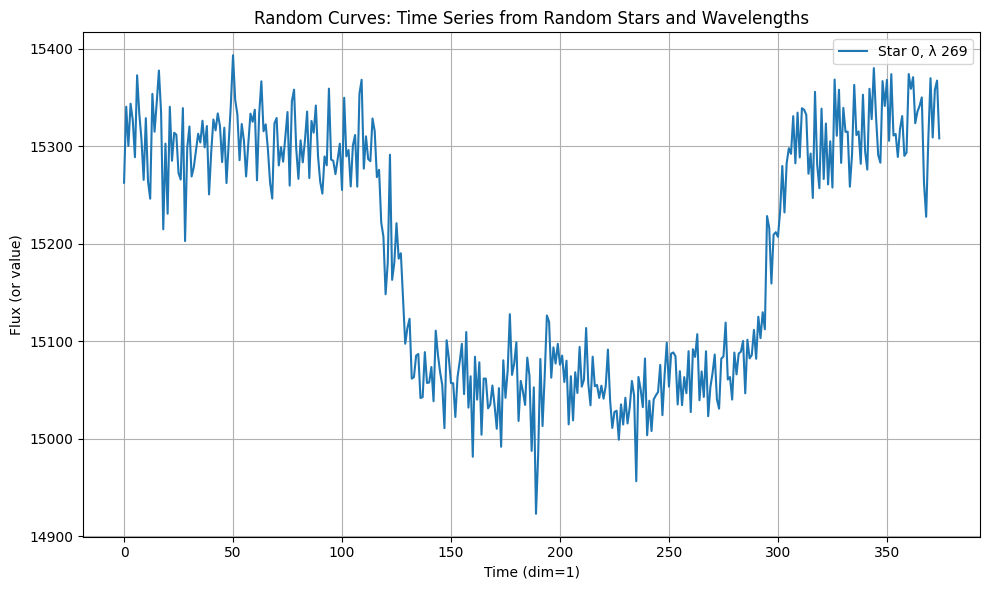

In [27]:
all_signal = np.load(paths.signal_path)
plot_spectra(all_signal, num_curves=1)

In [28]:
if not SUBMIT_TO_COMPETITION:
    bad_planet_idx = id_to_idx[1665810843]
    plot_spectra(all_signal, sum_wavelengths=True, planet_idx = bad_planet_idx)

In [29]:
if not SUBMIT_TO_COMPETITION:
    bad_planet_idx = id_to_idx[1124834224]
    plot_spectra(all_signal, sum_wavelengths=True, planet_idx = bad_planet_idx)

In [30]:
if not SUBMIT_TO_COMPETITION:
    plot_spectra(all_signal, wavelength_idx=40, planet_idx = bad_planet_idx)

In [31]:
if not SUBMIT_TO_COMPETITION:
    plot_spectra(all_signal, planet_idx = 0)

In [32]:
if not SUBMIT_TO_COMPETITION:
    plot_spectra(all_signal, planet_idx = 0, sum_wavelengths=True)

In [33]:
if not SUBMIT_TO_COMPETITION:
    plot_spectra(all_signal, num_curves=1, sum_wavelengths=True)

In [34]:
if not SUBMIT_TO_COMPETITION:
    plot_spectra(all_signal, planet_idx=0, num_curves=1, wavelength_idx=10)

In [35]:
if not SUBMIT_TO_COMPETITION:
    plot_spectra(binned_signal, planet_idx=0, num_curves=1, wavelength_idx=6)

In [36]:
if not SUBMIT_TO_COMPETITION:
    planet_idx  = random.randint(1, 1099)
    plot_spectra(all_signal, num_curves=1, planet_idx=planet_idx)

In [37]:
if not SUBMIT_TO_COMPETITION:
    bad_planet_idx = id_to_idx[1665810843]
    plot_spectra(all_signal, num_curves=1, planet_idx=bad_planet_idx)

## Curve Fitting

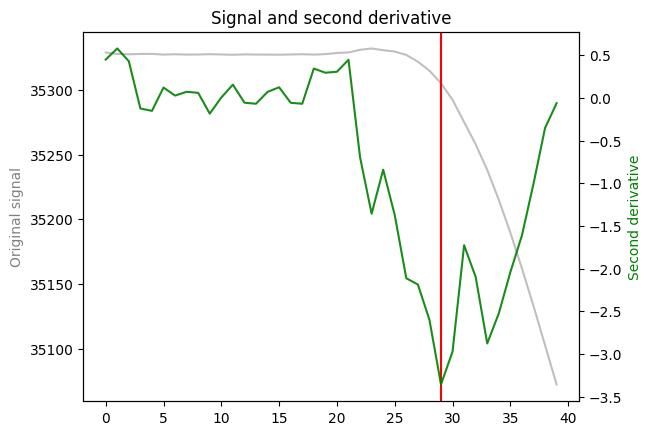

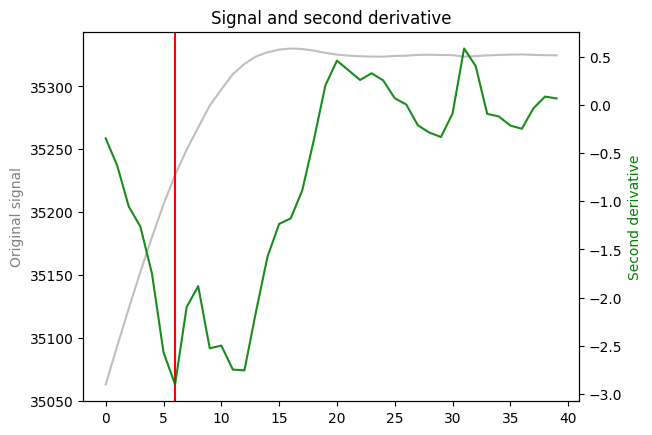

The left corner is 114 right is 303


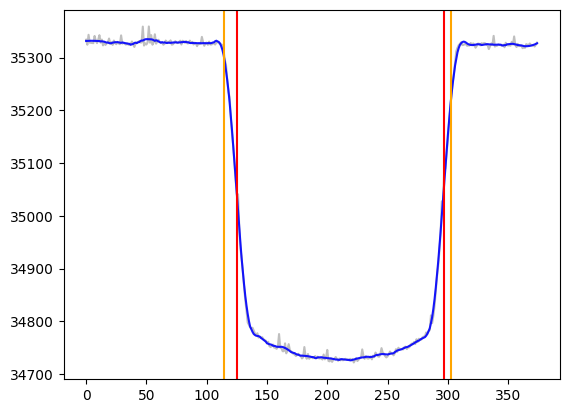

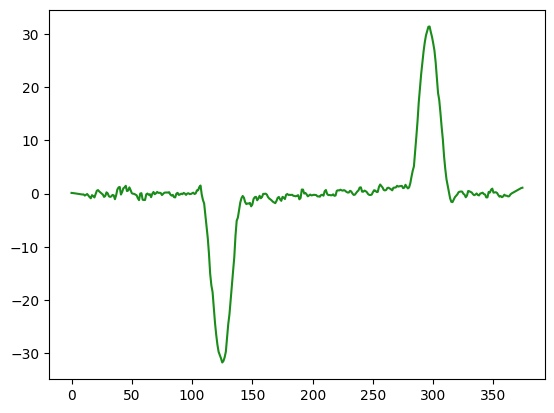

[(125, 297)]


In [38]:
breakpoints, edges = get_breakpoints(all_signal,
                                  TIME_BINS,
                                  TIME_BINS,
                                  buffer = TRANSITION_BUFFER,
                                  verbose=False)

print(breakpoints[:5])

In [39]:
missing_breakpoints = [entry for entry in breakpoints if None in entry]
#missing_breakpoints

In [40]:
star_info.head()

,Rs,Ms,Ts,Mp,e,P,sma,i,original_index
planet_id,,,,,,,,,
1103775,0.965432,0.9591,5539.03037,1.665007,0.0,6.932871,15.43293,89.533139,0


In [41]:
impacts = list((star_info['sma'] / star_info['Rs']) * np.cos(np.radians(star_info['i'])))
impacts[:5]

[0.13025285424300123]

In [42]:
if SUBMIT_TO_COMPETITION:
    bad_planets = []
    show_plots = False
else:
    bad_planet_ids = [1665810843, 2270815333] # 546732951, 2270815333,3224114655, 1370368610 ]  #[2401913267]   #[1665810843, 1739553248, 2757227373, 1124834224, 3352800080]   2401913267
    bad_planets = [id_to_idx[pid] for pid in bad_planet_ids]
    print(bad_planets)
    show_plots = True

#impact_list = list((star_info['sma'] / star_info['Rs']) * np.cos(star_info['i']))

poly_df, extra_feats_df, all_wl_fits = fit_all_curves(binned_signal,
                                                      centres,
                                                      star_info,
                                                      breakpoints,
                                                      edges,
                                                      days_per_bin =  4.6 * TIME_BINS / (60 * 60 * 24),
                                                      impacts = impacts,
                                                      scale=SCALE,
                                                      limb_law = 'quadratic',
                                                      buffer = TRANSITION_BUFFER,
                                                      bad_planets = bad_planets,
                                                      show_plots = show_plots,
                                                      max_edge_widths = (MAX_LEFT_EDGE, MAX_RIGHT_EDGE),
                                                      top_points = TOP_POINTS,
                                                      do_bat_fit = True
                                                      )


poly_df.head(3)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


,bin_0,bin_5,bin_29,bin_54,bin_79,bin_103,bin_128,bin_153,bin_178,bin_202,bin_227,bin_252,bin_277
planet_id,,,,,,,,,,,,,
1103775,0.017869,0.016893,0.016841,0.016943,0.016797,0.016837,0.016671,0.016671,0.016712,0.016706,0.016649,0.016854,0.01712


In [43]:
poly_df.head()

,bin_0,bin_5,bin_29,bin_54,bin_79,bin_103,bin_128,bin_153,bin_178,bin_202,bin_227,bin_252,bin_277
planet_id,,,,,,,,,,,,,
1103775,0.017869,0.016893,0.016841,0.016943,0.016797,0.016837,0.016671,0.016671,0.016712,0.016706,0.016649,0.016854,0.01712


In [44]:
extra_feats_df.describe()

,transit_width,max_wl_depth,mean_wl_depth,transit_residual_std,rel_noise,aspect,transit_fit_a,mean_depth,a,b,...,centre,right_transition,asymmetry,x_offset,bat_correction,fgs_diff,a_w2_depth,polypoints_range,polypoints_std,polypoints_mean
count,1.0,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,...,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000
mean,141.0,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,91.0,162.0,0.000002,71.0,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,141.0,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,91.0,162.0,0.000002,71.0,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138
25%,141.0,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,91.0,162.0,0.000002,71.0,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138
50%,141.0,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,91.0,162.0,0.000002,71.0,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138
75%,141.0,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,91.0,162.0,0.000002,71.0,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138
max,141.0,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,91.0,162.0,0.000002,71.0,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138


In [45]:
extra_feats_df.columns

Index(['transit_width', 'max_wl_depth', 'mean_wl_depth',
       'transit_residual_std', 'rel_noise', 'aspect', 'transit_fit_a',
       'mean_depth', 'a', 'b', 'c', 'a_c', 'delta', 'x_centre',
       'transit_delta', 'half_delta', 'transit_delta_width',
       'transit_half_delta_height', 'max_slope', 'fallback_factor',
       'transit_ratio', 'transit_ratio_2', 'has_no_breakpoints',
       'has_two_breakpoints', 'darkening_correction', 'left_transition',
       'centre', 'right_transition', 'asymmetry', 'reflected', 'x_offset',
       'bat_correction', 'fgs_diff', 'a_w2_depth', 'polypoints_range',
       'polypoints_std', 'polypoints_mean'],
      dtype='object')

In [46]:
extra_feats_df.head()

,transit_width,max_wl_depth,mean_wl_depth,transit_residual_std,rel_noise,aspect,transit_fit_a,mean_depth,a,b,...,right_transition,asymmetry,reflected,x_offset,bat_correction,fgs_diff,a_w2_depth,polypoints_range,polypoints_std,polypoints_mean
planet_id,,,,,,,,,,,,,,,,,,,,,
1103775,141,0.017011,0.01681,0.000025,0.001469,0.00016,2.146297e-07,0.01681,2.496438e-07,3.813539e-07,...,162,0.000002,True,71,0.004346,0.00098,-0.001592,0.00122,0.000138,0.000138


In [47]:
#if len(poly_df) > 1:
#    print("So far so good,  let's wait for an hour...")
#    time.sleep(3600)  # pause for 4800 seconds
#    print("Resuming execution...")

## Corrective model training
### Prepare Targets

In [48]:
if TRAIN_NEW_MODELS:
    targ_df = load_target(paths.train_csv, planet_ids) 
    display(targ_df.head(3))

In [49]:
if TRAIN_NEW_MODELS:
    target_df = transform_target(targ_df, poly_df, centres, planet_ids)
    display(target_df.head(3))

### Feature Engineering

In [50]:
star_info.head()

,Rs,Ms,Ts,Mp,e,P,sma,i,original_index
planet_id,,,,,,,,,
1103775,0.965432,0.9591,5539.03037,1.665007,0.0,6.932871,15.43293,89.533139,0


In [51]:
poly_df.head()

,bin_0,bin_5,bin_29,bin_54,bin_79,bin_103,bin_128,bin_153,bin_178,bin_202,bin_227,bin_252,bin_277
planet_id,,,,,,,,,,,,,
1103775,0.017869,0.016893,0.016841,0.016943,0.016797,0.016837,0.016671,0.016671,0.016712,0.016706,0.016649,0.016854,0.01712


In [52]:
feat_dfs = feature_eng(poly_df,
                       extra_feats_df,
                       star_info,
                       all_wl_fits,
                       FIT_FEATURES)

In [53]:
feat_dfs['bin_0'].head()

,polypoints_std,polypoints_range,transit_fit_a,bat_correction,Rs,Ms,Ts,Mp,P,sma,...,bin_252,bin_277,wl_bat_correction,wl_c_c,wl_max_slope,wl_a,wl_b,wl_c,wl_a_c,wl_transit_delta
1103775,0.000138,0.00122,2.146297e-07,0.004346,0.965432,0.9591,5539.03037,1.665007,6.932871,15.43293,...,0.016854,0.01712,-0.232989,-0.000155,0.000048,6.859849e-07,0.000003,1.007457,6.809074e-07,0.003408


In [54]:
feat_dfs['bin_0'].head()

,polypoints_std,polypoints_range,transit_fit_a,bat_correction,Rs,Ms,Ts,Mp,P,sma,...,bin_252,bin_277,wl_bat_correction,wl_c_c,wl_max_slope,wl_a,wl_b,wl_c,wl_a_c,wl_transit_delta
1103775,0.000138,0.00122,2.146297e-07,0.004346,0.965432,0.9591,5539.03037,1.665007,6.932871,15.43293,...,0.016854,0.01712,-0.232989,-0.000155,0.000048,6.859849e-07,0.000003,1.007457,6.809074e-07,0.003408


### PCA and MI analysis

In [55]:
if FIT_PCA and TRAIN_NEW_MODELS:
    first_bin = poly_df.columns[1]
    display(first_bin)
    X = feat_dfs[first_bin].copy()#.drop(columns = ['has_two_breakpoints'])
    X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(X_scaled, )
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    display(X_pca.head())

In [56]:
if FIT_PCA and TRAIN_NEW_MODELS:
    y = target_df[first_bin].copy()
    y = y.loc[y.index.intersection(X.index)]
    mi_scores = mutual_info_regression(X_pca, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_pca.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    ordered_scores = list(mi_scores.index)
    display(mi_scores)

In [57]:
if FIT_PCA and TRAIN_NEW_MODELS:
    loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns)[ordered_scores] # and the rows are the original features
    display(loadings)

Let's repeat this but use a pipeline to pass the transform to inference

In [58]:
if FIT_PCA and TRAIN_NEW_MODELS:
    preprocess = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=PCA_FEATURES))
    ])

    X_train_transformed = preprocess.fit_transform(X)

    joblib.dump(preprocess, paths.fit_pipeline)


    pca_columns = [f"PC{i+1}" for i in range(X_train_transformed.shape[1])]

    X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    index=X.index,     # preserve row indices
    columns=pca_columns      # give meaningful column names
    )

    display(X_train_transformed_df.head())
else:
    preprocess = None
    

Create splits by dataframe index

In [59]:
random_ids = planet_ids.copy()
random_ids = [x for x in random_ids if x not in EXCLUDE_PLANETS]
random.shuffle(random_ids)

test_size = int(len(planet_ids) // FOLDS)

fold_ids={}
for outer_fold in range(FOLDS):
    test_ids = random_ids[test_size * outer_fold : test_size * (outer_fold + 1)]
    remaining = [id for id in random_ids if id not in test_ids]
    val_size = int(len(remaining) /INNER_FOLDS)
    val_ids = {}
    train_ids = {}
    random.shuffle(remaining)
    for n in range(INNER_FOLDS):
        val_id_pool = remaining[n*val_size : (n+1)*val_size]
        sub_pool_size = (INNER_FOLDS-1) * len(val_id_pool) // INNER_FOLDS  
        val_sub_pool = val_id_pool[:sub_pool_size]
        val_ids[f'f{n}_val'] = val_id_pool
        train_id_pool = [planet for planet in remaining if planet not in val_ids[f'f{n}_val'] ]
        if MIX_SPLITS:
            #Super-dodgy, but with not much to loose at this stage, let's try it anyway
            train_id_pool = train_id_pool + val_sub_pool
        train_ids[f'f{n}_train'] = train_id_pool

    fold_ids[outer_fold] = {'train_ids': train_ids, 'val_ids': val_ids, 'test_ids': test_ids}  #None of these will contain EXCLUDED_PLANETS

In [60]:
if TRAIN_NEW_MODELS:
    feat_imps = []
    for outer_fold in tqdm(range(FOLDS)):
        outer_destn = paths.pred_models / f'outer_fold_{outer_fold}'
        outer_destn.mkdir(exist_ok=True)
        for inner_fold in range(INNER_FOLDS):
            models, feature_imp = train_models(feat_dfs,
                                                target_df,
                                                fold_ids[outer_fold]['train_ids'][f'f{inner_fold}_train'],
                                                fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'],
                                                LGBM_FIT_PARAMETERS,
                                                preprocess,
                                                EARLY_STOPPING)
            inner_destn = outer_destn / f'fold_{inner_fold}'
            inner_destn.mkdir(exist_ok=True)
            feat_imps.append(feature_imp)
            for name, model in models.items():
                joblib.dump(model, inner_destn / f'{name}.pkl')
    feat_imp_df = pd.concat(feat_imps, axis=0)

No value:
mean_wl_depth, polypoints_mean, has_two_breakpoints, has_no_breakpoints, e

In [61]:
if TRAIN_NEW_MODELS:
    plt.figure(figsize=(6, 8))
    sns.barplot(x="Value", y="Feature", data=feat_imp_df)
    plt.show()

In [62]:
models = {}
for outer_fold in range(FOLDS):
    inner_models = {}
    for inner_fold in range(INNER_FOLDS):
        fold_path = paths.pred_models / f'outer_fold_{outer_fold}' / f'fold_{inner_fold}'
        pkl_files = list(fold_path.glob('*.pkl'))
        bin_models = {}
        for model in pkl_files:
            bin_models[model.stem] = joblib.load(model)
        inner_models[f'fold_{inner_fold}'] = bin_models
    models[outer_fold] = inner_models

preprocess = joblib.load(paths.fit_pipeline) if FIT_PCA else None

In [63]:
offset_predictions = {}
for outer_fold in tqdm(range(FOLDS)):
    for inner_fold in range(INNER_FOLDS):
        predictions = {}
        for bin_id, model in  models[outer_fold][f'fold_{inner_fold}'].items():
            if FIT_PCA:
                pca_feats = preprocess.transform(feat_dfs[bin_id])#.drop(columns = ['has_two_breakpoints'])
                pca_columns = [f"PC{i+1}" for i in range(pca_feats.shape[1])]
                pca_feat_df = pd.DataFrame(
                                        pca_feats,
                                        index=feat_dfs[bin_id].index,
                                        columns=pca_columns
                                        )
                wl_feats = pd.concat([feat_dfs[bin_id], pca_feat_df], axis=1)
            else:
                wl_feats = feat_dfs[bin_id]
            predictions[bin_id] =  model.predict(wl_feats)
        pred_df = pd.DataFrame(predictions, index=feat_dfs['bin_0'].index)
        pred_df = pred_df.reindex(columns=poly_df.columns)
        offset_predictions[f'fold_{outer_fold}_{inner_fold}'] = pred_df

offset_predictions['fold_0_0'].head(2)

100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


,bin_0,bin_5,bin_29,bin_54,bin_79,bin_103,bin_128,bin_153,bin_178,bin_202,bin_227,bin_252,bin_277
1103775,-0.002078,-0.001015,-0.000972,-0.000973,-0.000822,-0.000858,-0.000716,-0.000754,-0.000714,-0.000706,-0.000706,-0.000881,-0.001096


## High resolution fit

What we want to know is how big are the maximum second-order differences, over all the bins,  the approach below only looks at bin_0!

In [64]:
second_diffs = pd.DataFrame({
    key: df['mean_second_diff']
    for key, df in feat_dfs.items()
})
second_diffs['row_max_excl_first2'] = second_diffs.iloc[:, 2:].max(axis=1)

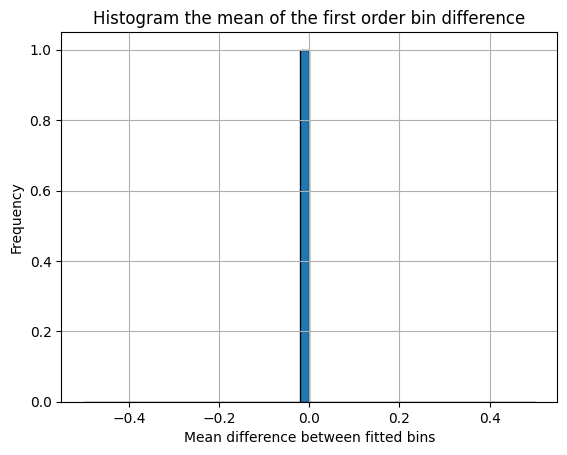

In [65]:
second_diffs["row_max_excl_first2"].hist(bins=50, edgecolor="black")
plt.xlabel("Mean difference between fitted bins")
plt.ylabel("Frequency")
plt.title("Histogram the mean of the first order bin difference")
plt.show()

In [66]:
max_mean_diff = second_diffs["row_max_excl_first2"].max()
norm_differences = (second_diffs["row_max_excl_first2"] / max_mean_diff).to_list()

In [67]:
convolved_signal = midprocessor.convolve_wavelengths_skip_first(differences = norm_differences)
all_centres = [idx for idx in range(1, convolved_signal.shape[2] + 1)]

In [68]:
high_res_df, _, _ = fit_all_curves(convolved_signal,
                                   all_centres,
                                   star_info,
                                   breakpoints,
                                   edges,
                                   days_per_bin =  4.6 * TIME_BINS / (60 * 60 * 24),
                                   impacts = impacts,
                                   scale=SCALE,
                                   limb_law = 'quadratic',
                                   buffer = TRANSITION_BUFFER,
                                   bad_planets = [],
                                   show_plots = False,
                                   max_edge_widths = (MAX_LEFT_EDGE,MAX_RIGHT_EDGE),
                                   top_points = TOP_POINTS,
                                   do_bat_fit = False
                                   )

high_res_df.head(3)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_273,bin_274,bin_275,bin_276,bin_277,bin_278,bin_279,bin_280,bin_281,bin_282
planet_id,,,,,,,,,,,,,,,,,,,,,
1103775,0.017869,0.016858,0.016853,0.016853,0.016859,0.016871,0.016881,0.016893,0.0169,0.016901,...,0.017291,0.01742,0.017512,0.017555,0.01757,0.017576,0.017576,0.017594,0.017646,0.017722


## Postprocessing

In [69]:
high_res_predictions = {}

for outer_fold in range(FOLDS):
    fold_predictions = {}
    for inner_fold in range(INNER_FOLDS):
        offset_df = offset_predictions[f'fold_{outer_fold}_{inner_fold}'] 
        fgs_clipped = offset_df.iloc[:,:1].values.clip(min = -FGS_MAX_SHIFT, max = FGS_MAX_SHIFT)
        airs_clipped = offset_df.iloc[:,1:].values.clip(min = -AIRS_MAX_SHIFT, max = AIRS_MAX_SHIFT)
        interpolated_airs = interpolate_predictions(airs_clipped, centres, kind='quadratic')  #Doing this because the offset dataframe has only 13 points
        interpolated = np.concatenate([fgs_clipped, interpolated_airs], axis=1)
        fold_predictions[f'fold_{inner_fold}']  = high_res_df.values + interpolated
    high_res_predictions[outer_fold] = fold_predictions

high_res_predictions[0]['fold_0'][0,:5]

array([0.0157914 , 0.01584263, 0.01583723, 0.01583719, 0.01584359])

In [70]:
interp_predictions = {}

for outer_fold in range(FOLDS):
    fold_predictions = {}
    for inner_fold in range(INNER_FOLDS):
        offset_df = offset_predictions[f'fold_{outer_fold}_{inner_fold}'] 
        fgs_clipped = offset_df.iloc[:,:1].values.clip(min = -FGS_MAX_SHIFT, max = FGS_MAX_SHIFT)
        airs_clipped = offset_df.iloc[:,1:].values.clip(min = -AIRS_MAX_SHIFT, max = AIRS_MAX_SHIFT)
        interpolated_airs = interpolate_predictions(airs_clipped, centres, kind='quadratic')  #quadratic, linear
        interpolated_fits =  interpolate_predictions(poly_df.values[:,1:], centres, kind='quadratic')
        fgs_predictions = fgs_clipped + poly_df.values[:,:1]
        airs_predictions = interpolated_airs + interpolated_fits
        fold_predictions[f'fold_{inner_fold}']  = np.concatenate([fgs_predictions, airs_predictions], axis=1)
    interp_predictions[outer_fold] = fold_predictions

interp_predictions[0]['fold_0'][0,:5]

array([0.0157914 , 0.01587815, 0.01587839, 0.0158785 , 0.0158785 ])

Now select the high res for the planets with a large transmission range.

## Model the Uncertainty

In [71]:
def transform_target(df, poly_df, centres, ids):
    fgs1_vals = df.values[:,:1]
    airs_vals = df.values[:,centres]
    true_binned = np.concatenate([fgs1_vals, airs_vals], axis=1)
    col_names = ['bin_0'] + [f'bin_{centre}' for centre in centres]
    true_binned_df = pd.DataFrame(true_binned, index=ids, columns=col_names)
    target_df = pd.DataFrame(true_binned_df.values - poly_df.values, columns=true_binned_df.columns, index=true_binned_df.index) 
    return target_df

In [72]:
def bin_wavelengths_skip_first(self, data, method='mean'):
        if data.ndim != 3:
            raise ValueError("Input must be a 3D array (star, time, wavelength)")
    
        N, T, W = data.shape
        head = data[:, :, :1]  # Preserve first index (shape N, T, 1)
        tail = data[:, :, 1:]  # Wavelengths from index 1 onward (shape N, T, W-1)
    
        tail_len = tail.shape[-1]
        step_size = (tail_len-2*self.edge_buffer) / (self.wl_bins-1)
        half_kernel = self.binning_kernel // 2
        centres = [int(self.edge_buffer + (n + 1) * step_size) for n in range(self.wl_bins-2)]
    
        binned_list = []
    
        first_chunk = tail[:, :, :self.edge_buffer + half_kernel].mean(axis=-1, keepdims=True)
        last_chunk = tail[:, :, -half_kernel-self.edge_buffer:].mean(axis=-1, keepdims=True)
    
        binned_list = [first_chunk]
        for centre in centres:
            start = max(0, centre - half_kernel)
            end = min(tail_len, centre + half_kernel)
            chunk = tail[:, :, start:end]  # shape (N, T, kernel_size)
            binned_chunk = chunk.mean(axis=-1, keepdims=True)
            binned_list.append(binned_chunk)  # shape (N, T, 1)
        binned_list.append(last_chunk)
        tail_binned = np.concatenate(binned_list, axis=-1)  # shape (N, T, wl_bins)
        binned_data = np.concatenate([head, tail_binned], axis=2)  # shape (N, T, 1 + wl_bins)
    
        return binned_data, [self.edge_buffer] + centres + [W-1-self.edge_buffer]

#The centres are integers with respect to the airs columns (skips the first which is for FGS sensor),  for example  [5, 29, 54, 79, 103, 128, 153, 178, 202, 227, 252, 277]

In [73]:
def localized_rmse(df, col_indices, kernel_size):
    """
    Compute localized RMSE over sliding windows of columns.
        
    Returns
    -------
    pd.DataFrame
        DataFrame with one column per index in `col_indices`,
        each column containing the localized RMSE per row.
    """
    results = {}
    n_cols = df.shape[1]

    for idx in col_indices:
        # Define the window range
        left = max(0, idx - kernel_size)
        right = min(n_cols, idx + kernel_size + 1)
        
        # Extract subset and compute RMSE
        window = df.iloc[:, left:right]
        rmse = window.pow(2).mean(axis=1).pow(0.5)
        results[f"rmse_{idx}"] = rmse

    return pd.DataFrame(results, index=df.index)

In [74]:
def get_error_dfs(preds,
                  targets,
                  centres,
                  kernel_size = 35,
                  #error_factor = ERROR_FACTOR,
                  outer_folds = FOLDS,
                  inner_folds = INNER_FOLDS,
                  index = star_info.index
                  ):

    error_dfs = {}
    for outer_fold in range(outer_folds):
        for inner_fold in range(inner_folds):
            error_df = pd.DataFrame(preds[outer_fold][f'fold_{inner_fold}'] - targets.values, columns=targets.columns, index = index)   #So we want to bin this with bins matching the predictions.
            fgs_std = error_df.loc[fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val']].iloc[:, 0].abs() 
            airs_errors = error_df.iloc[:, 1:]
            airs_local_rmse = localized_rmse(airs_errors, centres, kernel_size=35)  #Estimates the rsme in a window around the list of centres
            airs_local_rmse = airs_local_rmse# * ERROR_FACTOR
            fgs_std_df = error_df.iloc[:, 0].abs().to_frame(name='rmse_0')# * ERROR_FACTOR  
            std_df = pd.concat([fgs_std_df, airs_local_rmse], axis=1)
            error_dfs[f'fold_{outer_fold}_{inner_fold}'] = std_df  #airs_local_rmse  #airs_std_df

    return error_dfs
    

In [75]:
if TRAIN_NEW_MODELS:
    lf_error_dfs = get_error_dfs(interp_predictions,targ_df, centres)
    hf_error_dfs = get_error_dfs(high_res_predictions,targ_df, centres)
    display(lf_error_dfs['fold_0_0'] )

**Now let's visualise this error and have a think about how to comine the hf predictions and interpolated predictions.**

In [76]:
def stack_and_plot_dfs(dfs, index = star_info.index):
    '''Take a dictionary of dataframes, stack them and take the mean, then plot a histogram'''
    arr = np.stack([df.to_numpy() for df in dfs.values()], axis=0)
    stacked_error_df = pd.concat(dfs, names=['source', 'original_index']).reset_index()  #So this dataframe has a 'localised error around each of the bins'

    plt.figure(figsize=(10, 6))
    values = stacked_error_df.iloc[:, 3:].values.ravel()
    mean_values = np.mean(values)
    print(mean_values)
    values = pd.Series(values).replace([np.inf, -np.inf], np.nan).dropna()
    sns.histplot(values, bins=40, kde=False)  
    plt.title('Histogram of Row-wise Standard Deviation')
    plt.xlabel('RMS error')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

if TRAIN_NEW_MODELS:
    stack_and_plot_dfs(lf_error_dfs)

In [77]:
if TRAIN_NEW_MODELS:
    stack_and_plot_dfs(hf_error_dfs)

Interesting result, but not completely unexpected.  Essentially we've binned the high-res df back into the same bins as the low-res df, so the 'localised' error is virtually identical.

Let's look at the overall rmse error for the whole curve.

In [78]:
def get_global_rmse(preds,
                    targets,
                    #error_factor=ERROR_FACTOR,
                    outer_folds=FOLDS,
                    inner_folds=INNER_FOLDS,
                    index=star_info.index,
                    exclude = EXCLUDE_PLANETS[0],
                    ):

    rmse_list = []
    for outer_fold in range(outer_folds):
        for inner_fold in range(inner_folds):
            error_df = pd.DataFrame(
                preds[outer_fold][f'fold_{inner_fold}'] - targets.values,
                columns=targets.columns,
                index=index
            ).drop(index=exclude)
            rmse = error_df.pow(2).mean(axis=1).pow(0.5) #* error_factor
            rmse_list.append(rmse)

    # Combine into DataFrame: rows = index, cols = folds
    rmse_df = pd.concat(rmse_list, axis=1)

    # Mean across folds
    return rmse_df.mean(axis=1)

In [79]:
if TRAIN_NEW_MODELS:
    hf_rmse = get_global_rmse(high_res_predictions, targ_df)
    lf_rmse =  get_global_rmse(interp_predictions, targ_df)
    display(np.mean(hf_rmse))
    display(np.mean(lf_rmse))

That's a huge win for the LF RMSE!    But I suspect the story is more nuanced.  Let's plot histograms.

In [80]:
if TRAIN_NEW_MODELS:
    rmse_df = pd.DataFrame({
                            "High-res": hf_rmse,
                            "Low-res": lf_rmse
                            }).melt(var_name="Type", value_name="RMSE")
    
    # Clean up infinities and NaNs
    rmse_df = rmse_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["RMSE"])
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=rmse_df, x="RMSE", hue="Type", bins=50, alpha=0.5, kde=False)
    
    plt.xlabel("Mean RMSE across folds (per index)")
    plt.yscale('log')
    plt.ylabel("Frequency")
    plt.title("Distribution of RMSE (High-res vs Low-res)")
    plt.show()

Now the trick is to figure out if there is a feature that could seperate these two.

In [81]:
if TRAIN_NEW_MODELS:
    difference_df = lf_rmse - hf_rmse  #negative means that hf_rmse is a larger value, therefore lf_rmse is a better choice

    plt.figure(figsize=(10, 6))
    sns.histplot(data=difference_df, bins=50, alpha=0.5, kde=False)
    
    plt.xlabel("Mean RMSE across folds (per index)")
    plt.yscale('log')
    plt.ylabel("Frequency")
    plt.title("Distribution of RMSE (High-res vs Low-res)")
    plt.show()

In [82]:
if TRAIN_NEW_MODELS:
    cols_of_interest = ['polypoints_std', 'polypoints_range', 'rel_noise', 'mean_first_diff', 'mean_second_diff']  #I've inspected the rest, none looked helpful    'has_two_breakpoints'

    for col in cols_of_interest:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=feat_dfs['bin_0'][col], y=difference_df, s=5)
        plt.xlabel(col)
        plt.axhline(0, color='red', linestyle='--', linewidth=1)  # horizontal line at 0
        plt.ylabel("Interpolated rmse - fully fitted rmse")
        plt.title(f"{difference_df.name} vs {col}")
        plt.show()

So in general it's better to use the interpolated fit.     Could try 'mean_first_diff' > 0.0008  as a mask to select the hf fit.  We would get a decent way to select the better samples for hf fitting.   I suspect what is really going on here is something to do with relative noise, compared to the range/slope.  So creating a feature like this might help.  Might also try adding  'has_two_breakpoints'  to the condition

In [83]:
mask = (feat_dfs['bin_0']['mean_first_diff'] < USE_INTERPOLATED_FIT_THRESHOLD).to_numpy()[:, None]   #fold doesn't matter here
combined_predictions = {}

for outer_fold in range(FOLDS):
    inner_fold_predictions = {}
    for inner_fold in range(INNER_FOLDS):
        combined_preds =  np.where(mask, interp_predictions[outer_fold][f'fold_{inner_fold}'], high_res_predictions[outer_fold][f'fold_{inner_fold}'])
        inner_fold_predictions[f'fold_{inner_fold}'] = combined_preds
    combined_predictions[outer_fold] = inner_fold_predictions

combined_predictions[0]['fold_0'].shape

(1, 283)

In [84]:
if TRAIN_NEW_MODELS:
    error_dfs = {}
    for outer_fold in range(FOLDS):
        for inner_fold in range(INNER_FOLDS):
            error_df = pd.DataFrame(combined_predictions[outer_fold][f'fold_{inner_fold}'] - targ_df.values, columns=targ_df.columns, index = star_info.index)   #So we want to bin this with bins matching the predictions.
            fgs_std = error_df.loc[fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val']].iloc[:, 0].abs() 
            airs_errors = error_df.iloc[:, 1:]
            airs_local_rmse = localized_rmse(airs_errors, centres, kernel_size=35)  #Estimates the rsme in a window around the list of centres
            #airs_local_rmse = airs_local_rmse * ERROR_FACTOR
            fgs_std_df = error_df.iloc[:, 0].abs().to_frame(name='rmse_0') #* ERROR_FACTOR
            std_df = pd.concat([fgs_std_df, airs_local_rmse], axis=1)
            error_dfs[f'fold_{outer_fold}_{inner_fold}'] = std_df

In [85]:
def stack_and_plot_dfs(dfs, index = star_info.index):
    '''Take a dictionary of dataframes, stack them and take the mean, then plot a histogram'''
    arr = np.stack([df.to_numpy() for df in dfs.values()], axis=0)
    mean_arr = arr.mean(axis=0)
    mean_error_df = pd.DataFrame(mean_arr, index = index)  #, columns = [0] + [centres]
    stacked_error_df = pd.concat(error_dfs, names=['source', 'original_index']).reset_index()  #So this dataframe has a 'localised error around each of the bins'

    plt.figure(figsize=(10, 6))
    values = stacked_error_df.iloc[:, 3:].values.ravel()
    values = pd.Series(values).replace([np.inf, -np.inf], np.nan).dropna()
    sns.histplot(values, bins=40, kde=False)  
    plt.title('Histogram of Row-wise Standard Deviation')
    plt.xlabel('RMS error')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    

In [86]:
if TRAIN_NEW_MODELS:
    rmse_cols = [b.replace("bin_", "rmse_") for b in poly_df.columns]
    arr = np.stack([df.to_numpy() for df in error_dfs.values()], axis=0)
    print(arr.shape)

    # Take mean over that axis This is for visualisation only, no worries about data leakage
    mean_arr = arr.mean(axis=0)
    
    # Rebuild DataFrame
    mean_error_df = pd.DataFrame(mean_arr, index=star_info.index, columns = rmse_cols)  #, columns = [0] + [centres]
    stacked_error_df = pd.concat(error_dfs, names=['source', 'original_index']).reset_index()  #So this dataframe has a 'localised error around each of the bins'

In [87]:
if TRAIN_NEW_MODELS:
    plt.figure(figsize=(10, 6))
    values = stacked_error_df.iloc[:, 3:].values.ravel()
    values = pd.Series(values).replace([np.inf, -np.inf], np.nan).dropna()
    sns.histplot(values, bins=40, kde=False)  
    plt.title('Histogram of Row-wise Standard Deviation')
    plt.xlabel('RMS error')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

In [88]:
if TRAIN_NEW_MODELS:
    airs_badies = list(stacked_error_df[stacked_error_df[f'rmse_{centres[0]}'] >= 0.002]['original_index'].unique())
    print(airs_badies)

In [89]:
def get_local_features(bins_df, preds, high_res_df, hf_preds, lf_preds, centre, kernel_size=19):
    '''Derive features related to the local behavior around the bin centre
       bins_df:  Predicted offsets from previous LGBM model for this fold
       preds_df:  Fitted Polynomials for every point
       centre:  The bin index,  ie bin_{centre}
    '''
    
    def mean_bin_diff_at_col(df, col_name):
        """
        Compute mean difference for a given column name in a DataFrame.
        - Middle columns: difference to mean of neighbors
        - Edge columns: difference to single neighbor
        """
        cols = df.columns
        col_idx = cols.get_loc(col_name)  # get positional index
        n_cols = len(cols)
    
        if col_idx == 0:
            # first column, only right neighbor
            return df[col_name] - df.iloc[:, col_idx + 1]
        elif col_idx == n_cols - 1:
            # last column, only left neighbor
            return df[col_name] - df.iloc[:, col_idx - 1]
        else:
            # middle columns, average of left and right
            return df[col_name] - (df.iloc[:, col_idx - 1] + df.iloc[:, col_idx + 1]) / 2

    #preds = preds_df.values
    bins = bins_df.values
    
    bin_names = list(bins_df.columns)
    bin_idxs = [int(b.split("_")[1]) for b in bin_names]
    

    
    min_idx = max(0, centre - kernel_size//2)
    max_idx = min(preds.shape[1], centre + kernel_size//2)
    local_col_idxs = list(range(min_idx, max_idx))

    local_bins = bins_df[f'bin_{centre}'].values
    local_preds = preds[:,local_col_idxs]
    local_first_diffs = np.diff(local_preds, n=1, axis=1)
    local_second_diffs = np.diff(local_preds, n=2, axis=1)


    local_mean_first_diffs = np.mean(local_first_diffs, axis=1)
    local_max_second_diffs = np.max(local_second_diffs, axis=1)
    local_mean_second_diffs = np.mean(local_second_diffs, axis=1)

    
    
    local_means = np.mean(local_preds, axis=1)
    local_residuals = local_preds -  preds[:,[centre]]

    local_residuals_mean = np.mean(local_residuals, axis=1)
    local_residuals_std = np.std(local_residuals, axis=1)
    # flatten the difference to 1D
    local_mean_diff = (local_means - preds[:, centre])
    bin_slope = mean_bin_diff_at_col(bins_df, f'bin_{centre}').values

    local_hf_lf_diff = hf_preds - lf_preds 
    local_rms_hf_lf_diff =rms = np.sqrt(np.mean(local_hf_lf_diff**2, axis=1))

    

    local_feats = np.concatenate([local_residuals_mean[:, None],
                                 local_residuals_std[:, None],
                                 #local_mean_diff[:, None]
                                  bin_slope[:,None],
                                  #local_mean_first_diffs[:,None],
                                  local_max_second_diffs[:,None],
                                  #local_mean_second_diffs[:,None],
                                  #local_rms_hf_lf_diff[:,None]
                                 ],
                                 axis=1)

    col_names = ['local_residuals_mean', 'local_residuals_std', 'bin_slope', 'local_max_second_diffs', ] # 'local_mean_diff' 'local_mean_first_diffs',  'local_max_second_diffs', 'local_mean_second_diffs' 'local_rms_hf_lf_diff' 
    local_feats_df = pd.DataFrame(local_feats, index=bins_df.index, columns = col_names)
    
    return local_feats_df

In [90]:
def residual_by_savgol(X, window=51, polyorder=3):

    n_rows, n_cols = X.shape
    if window >= n_cols:
        window = n_cols - 1 if (n_cols - 1) % 2 == 1 else n_cols - 2
    if window % 2 == 0:
        window += 1
    
    trends = np.zeros_like(X)
    residuals = np.zeros_like(X)
    for i in range(n_rows):
        trends[i] = savgol_filter(X[i], window_length=window, polyorder=polyorder, mode='mirror')
        residuals[i] = X[i] - trends[i]
    return residuals 


def get_global_features(binned_offsets,
                        binned_fits,
                        high_res_fits,
                        hf_preds,
                        lf_preds):

    lf_residuals = residual_by_savgol(high_res_fits.values, window=51)
    hf_residuals = residual_by_savgol(high_res_fits.values, window=11)

    rms_offset = np.sqrt(np.mean(binned_offsets**2, axis=1))
    rms_residual_lf = np.sqrt(np.mean(lf_residuals**2, axis=1))
    max_residual_lf = np.sqrt(np.max(lf_residuals**2, axis=1))
    rms_residual_hf = np.sqrt(np.mean(hf_residuals**2, axis=1))
    max_residual_hf = np.sqrt(np.max(hf_residuals**2, axis=1))
    binned_fits_range = np.ptp(binned_fits.iloc[:, 1:].values, axis=1)
    hf_residual_bin_range_ratio = rms_residual_hf / binned_fits_range
    
    hf_lf_diff = hf_preds - lf_preds
    hf_lf_rms_diff = np.sqrt(np.mean(hf_lf_diff**2, axis=1))

    global_df = pd.DataFrame({
        'rms_residual_lf': rms_residual_lf,
        'max_residual_lf': max_residual_lf,   
        #'rms_residual_hf': rms_residual_hf,   #removed for batman version
        #'max_residual_hf': max_residual_hf,   #removed for batman version 
        'rms_offset': rms_offset,
        'hf_residual_bin_range_ratio': hf_residual_bin_range_ratio,
        'hf_lf_rms_diff': hf_lf_rms_diff,
    }, index=high_res_fits.index)

    return global_df

In [91]:
fold_features = {}
for outer_fold in range(FOLDS):
    #Let's create a feature here from the variance of the inner fold predictions for the outer-fold
    #We can work directly with the offsets, since all folds use the same base fit
    offset_dfs = [offset_predictions[f'fold_{outer_fold}_{inner_fold}'] for inner_fold in range(INNER_FOLDS)]

    stacked = np.stack([df.values for df in offset_dfs], axis=0)
    std_values = np.std(stacked, axis=0, ddof=0) 
    columns = [f'std_{col}' for col in offset_dfs[0].columns]
    fold_rms_df = pd.DataFrame(std_values, index=offset_dfs[0].index, columns=columns)
    #columns will have headers rms_rmse_**
    
    for inner_fold in range(INNER_FOLDS):
        binned_preds_df = offset_predictions[f'fold_{outer_fold}_{inner_fold}'].copy()
        features_df = pd.concat([extra_feats_df, star_info], axis = 1)
        features_df = features_df[ERROR_FEATURES]
        lf_preds_df = interp_predictions[outer_fold][f'fold_{inner_fold}']
        hf_preds_df = high_res_predictions[outer_fold][f'fold_{inner_fold}']
        comb_preds = combined_predictions[outer_fold][f'fold_{inner_fold}']
        
        features_df = pd.concat([binned_preds_df,
                                 #poly_df,
                                 features_df], axis = 1)
        
        features_df = features_df[ERROR_FEATURES + list(binned_preds_df.columns)]  #Need to add bin-specific features here

        global_features_df = get_global_features(binned_preds_df, poly_df, high_res_df, hf_preds_df, lf_preds_df)
        #global_features_df['use_interpolated'] = (features_df['polypoints_range'] <= USE_INTERPOLATED_FIT_THRESHOLD).astype(int)

        features_dfs = {}
        for centre in [0] + centres:
            local_features_df = get_local_features(binned_preds_df,
                                                   comb_preds,  #Numpy array
                                                   high_res_df,
                                                   hf_preds_df,
                                                   lf_preds_df,
                                                   centre,
                                                   kernel_size = 19)
            
            local_fit_features = feat_dfs[f'bin_{centre}'][LGBM_LOCAL_ERROR_FEATURES]

            #local_std_df = fold_rms_df[f'std_bin_{centre}'].rename(columns={f'std_bin_{centre}': 'fold_std'})
            local_std_df = fold_rms_df[[f'std_bin_{centre}']]#.rename(columns={f'bin_std_bin_{centre}': 'my_col'})
            local_std_df.columns = ['fold_bin_std']
        
            features_dfs[f'rmse_{centre}'] =  pd.concat([features_df, 
                                                         global_features_df,
                                                         local_features_df,
                                                         local_fit_features,
                                                         local_std_df,
                                                         #global_features_df
                                                        ], axis=1)
            #{f'rmse_{centre}':features_df for centre in [0] + centres}
        
        fold_features[f'fold_{outer_fold}_{inner_fold}'] = features_dfs 

In [92]:
def plot_one_feature(df, error_df, feature):
    plt.figure(figsize=(6, 4))
    cols = error_df.columns
    plt.scatter(df[feature], error_df[cols[1]], s=1)
    plt.xlabel(feature)
    plt.ylabel('rmse')
    plt.title(f'Scatter Plot with error feature {feature}')
    plt.tight_layout()
    plt.show()

'mean_wl_depth',
'aspect',
 'polypoints_range',
 'polypoints_std',
 'polypoints_mean',
 'c',
 'delta',
 'mean_first_diff',
 'mean_second_diff'

In [93]:
all_dfs = [df for outer in fold_features.values() for df in outer.values()]
stacked = pd.concat(all_dfs, axis=0, ignore_index=True)
mean_features_df = pd.concat(all_dfs).groupby(level=0).mean()

In [94]:
if TRAIN_NEW_MODELS:
    cols_to_plot = set(mean_features_df.columns) - set(poly_df.columns)
    for feature in cols_to_plot:
        plot_one_feature(mean_features_df.drop(index = EXCLUDE_PLANETS),
                         mean_error_df.drop(index = EXCLUDE_PLANETS),
                         feature)

In [95]:
#linear_features = ['mean_wl_depth', 'polypoints_range', 'polypoints_std', 'cos_i', 'a', 'b', 'c', 'delta']
#if TRAIN_NEW_MODELS:
#    for outer_fold in tqdm(range(FOLDS)):
#        outer_destn = paths.error_models / f'outer_fold_{outer_fold}'
#        outer_destn.mkdir(exist_ok=True)
#        for inner_fold in range(4):
#            val_std_ids = random.sample(fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'], k=len(fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'])//10)
#            train_std_ids = [planet for planet in fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'] if planet not in val_std_ids]

#            features = fold_features[f'fold_{outer_fold}_{inner_fold}'][linear_features]
#            error_model = train_linear_model(features = features,
#                                             targets = airs_error_dfs[f'fold_{outer_fold}_{inner_fold}'].abs(),
#                                             train_ids = train_std_ids,
#                                             val_ids = val_std_ids)
#        
#            destn = outer_destn / f'fold_{inner_fold}'
#            destn.mkdir(exist_ok=True)
#            joblib.dump(error_model, destn / 'airs_std.pkl')

In [96]:
fold_features['fold_0_0'].keys()

dict_keys(['rmse_0', 'rmse_5', 'rmse_29', 'rmse_54', 'rmse_79', 'rmse_103', 'rmse_128', 'rmse_153', 'rmse_178', 'rmse_202', 'rmse_227', 'rmse_252', 'rmse_277'])

In [97]:
if ERROR_PCA and TRAIN_NEW_MODELS:
    first_bin = 'rmse_5'  #fold_features['fold_0_0'].columns[1]
    X = fold_features['fold_0_0'][first_bin].copy()#.drop(columns = ['use_interpolated'])
    error_preprocess = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=PCA_ERROR_FEATURES))
    ])

    X_train_transformed = error_preprocess.fit_transform(X)

    joblib.dump(error_preprocess, paths.error_pipeline)
    
    pca_columns = [f"PC{i+1}" for i in range(X_train_transformed.shape[1])]

    X_train_transformed_df = pd.DataFrame(
        X_train_transformed,
        index=X.index,     # preserve row indices
        columns=pca_columns      # give meaningful column names
        )

    display(X_train_transformed_df.head(3))
else:
    error_preprocess = None

In [98]:
def train_error_models(features: dict, # Dict of DataFrames with keys bin_##  
                       targets: pd.DataFrame,
                       train_ids,
                       val_ids,
                       model_parameters,
                       pipeline,  #preprocessing pipeline for PCA features
                       early_stopping,
                       ):

    if not early_stopping:
        train_ids = train_ids + val_ids  #no need for a split anymore
    
    targets_train = targets.loc[train_ids]
    targets_val = targets.loc[val_ids]

    models = {}
    feature_imps = []

    for target_col in tqdm(targets.columns):
        X_pre_transformed = features[target_col]#.drop(columns = ['use_interpolated'])

        if pipeline is not None:
            X_trfmd = pipeline.transform(X_pre_transformed)
            pca_columns = [f"PC{i+1}" for i in range(X_trfmd.shape[1])]
            X_df = pd.DataFrame(
                                        X_trfmd,
                                        index=features[target_col].index,
                                        columns=pca_columns
                                        )
    
            X = pd.concat([features[target_col], X_df], axis=1)
        else:
            X = features[target_col]
        
        X_train = X.loc[train_ids]
        X_val = X.loc[val_ids]
        feature_list = list(X.columns)
        
        y_train = targets_train[target_col]
        y_val = targets_val[target_col]
                
        model = lgb.LGBMRegressor(**model_parameters)

        if early_stopping:
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      eval_metric="l2",
                      callbacks=[lgb.early_stopping(300)]
                     )
        else:
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      eval_metric="l2",
                     )
            
        models[target_col] = model
        feature_imps.append(pd.DataFrame(sorted(zip(model.feature_importances_, feature_list)), columns=['Value','Feature']))
    return models, pd.concat(feature_imps, axis=0)

In [99]:
#rmse_target_columns = list(error_dfs['fold_0_0'].columns)
if ERROR_PCA:
    error_preprocess = joblib.load(paths.error_pipeline)
else:
    error_preprocess = None

In [100]:
error_feat_imps = []
if TRAIN_NEW_MODELS:
    for outer_fold in range(FOLDS):
        outer_destn = paths.error_models / f'outer_fold_{outer_fold}'
        outer_destn.mkdir(exist_ok=True)
        for inner_fold in range(INNER_FOLDS):
            val_std_ids = random.sample(fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'], k=len(fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'])//10)
            train_std_ids = [planet for planet in fold_ids[outer_fold]['val_ids'][f'f{inner_fold}_val'] if planet not in val_std_ids]
                
            error_models, error_feat_imp = train_error_models(fold_features[f'fold_{outer_fold}_{inner_fold}'],  #features
                                                              error_dfs[f'fold_{outer_fold}_{inner_fold}'].abs(),  #targets
                                                              train_std_ids,
                                                              val_std_ids,
                                                              LGBM_ERROR_PARAMETERS,
                                                              error_preprocess,
                                                              EARLY_STOPPING,
                                                              )
        
            destn = outer_destn / f'fold_{inner_fold}'
            destn.mkdir(exist_ok=True)
            error_feat_imps.append(error_feat_imp)
            for name, model in error_models.items():
                joblib.dump(model, destn / f'{name}.pkl')

In [101]:
if TRAIN_NEW_MODELS:
    error_feat_imp_df = pd.concat(error_feat_imps, axis=0)
    plt.figure(figsize=(6, 8))
    sns.barplot(x="Value", y="Feature", data=error_feat_imp_df)  #.head(100)
    plt.show()

In [102]:
rmse_cols = [b.replace("bin_", "rmse_") for b in poly_df.columns]  
error_models = {}
for outer_fold in range(FOLDS):
    inner_models = {}
    for inner_fold in range(INNER_FOLDS):
        column_models = {}
        for column in rmse_cols:
            model_path = paths.error_models / f'outer_fold_{outer_fold}' / f'fold_{inner_fold}' / f'{column}.pkl'
            column_models[column] = joblib.load(model_path)
        inner_models[f'inner_fold_{inner_fold}'] = column_models
    error_models[f'outer_fold_{outer_fold}'] = inner_models

Let's re-sort the fallback factor into a more useful form

In [103]:
rows = {}
for idx, (row_idx, row) in enumerate(star_info.iterrows()):
    row = {}
    for col in poly_df.columns:
        wl_fit = all_wl_fits[idx][col]
        row[col] = wl_fit['fallback_factor']
    rows[idx] = row
fallback_df = pd.DataFrame.from_dict(rows, orient="index")
fallback_df.index = star_info.index
fallback_df.head()

,bin_0,bin_5,bin_29,bin_54,bin_79,bin_103,bin_128,bin_153,bin_178,bin_202,bin_227,bin_252,bin_277
planet_id,,,,,,,,,,,,,
1103775,1,1,1,1,1,1,1,1,1,1,1,1,1


In [104]:
fallback_df.stack().value_counts()

1    13
Name: count, dtype: int64

In [105]:
no_breakpoint_mask = (extra_feats_df['has_no_breakpoints'] == 1)

In [106]:
error_predictions = {}
for outer_fold in tqdm(range(FOLDS)):
    inner_predictions = {}
    for inner_fold in range(INNER_FOLDS):
        rsme_predictions= {}
        for rmse_id, model in  error_models[f'outer_fold_{outer_fold}'][f'inner_fold_{inner_fold}'].items():
            if ERROR_PCA:
                pca_feats = error_preprocess.transform(fold_features[f'fold_{outer_fold}_{inner_fold}'][rmse_id]) #.drop(columns = ['has_two_breakpoints'])) .drop(columns = ['has_two_breakpoints'])
                pca_columns = [f"PC{i+1}" for i in range(pca_feats.shape[1])]
                pca_feat_df = pd.DataFrame(pca_feats,
                                           index=fold_features[f'fold_{outer_fold}_{inner_fold}'][rmse_id].index,
                                           columns=pca_columns
                                           )
                wl_feats = pd.concat([fold_features[f'fold_{outer_fold}_{inner_fold}'][rmse_id], pca_feat_df], axis=1)
            else: wl_feats = fold_features[f'fold_{outer_fold}_{inner_fold}'][rmse_id]
            # success = feature_dfs[bin?]

            rsme_predictions[rmse_id] =  model.predict(wl_feats)  # success factor
            error_df = pd.DataFrame(rsme_predictions, index = feat_dfs['bin_0'].index)  #, index = feat_dfs['bin_0'].index
            error_df = error_df.reindex(columns=rmse_cols)

            #print(error_df.dtypes)       # make sure all are numeric
            #print(f'NaNs per column: {error_df.isna().sum()}') # count NaNs per column
            #print(f'The error df head: {error_df.head()}')
            #print(f'The error df shape: {error_df.shape}')

        
        error_df = pd.DataFrame(error_df.to_numpy() * fallback_df.to_numpy(),
                    index=error_df.index, columns=error_df.columns)

        error_df.loc[no_breakpoint_mask] = error_df.loc[no_breakpoint_mask] * NO_BREAKPOINTS_ERROR_FACTOR

        
        inner_predictions[f'fold_{inner_fold}'] = error_df
    error_predictions[outer_fold] = inner_predictions

print('The head from fold 0-0')
display(error_predictions[0]['fold_0'].head(2))

100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

The head from fold 0-0


,rmse_0,rmse_5,rmse_29,rmse_54,rmse_79,rmse_103,rmse_128,rmse_153,rmse_178,rmse_202,rmse_227,rmse_252,rmse_277
1103775,0.000226,0.000122,0.000169,0.000079,0.000095,0.000092,0.000116,0.000085,0.00013,0.000123,0.00015,0.000134,0.000167


In [107]:
fold_std = {}
for outer_fold in range(FOLDS):
    fold_error = error_predictions[outer_fold]
    stacked_error = np.abs(np.stack([values for values in fold_error.values()]))
    #stacked_error = np.clip(stacked_error, a_min=AIRS_MIN_SIGMA, a_max=AIRS_MAX_SIGMA)
    # Compute the mean across the first axis (i.e., across DataFrames)
    ensembled_error = np.sqrt((stacked_error**2).mean(axis=0))
    output_length = 282
    airs_error = ensembled_error[:,1:]
    pred_indices = [0] + centres + [output_length]  #rmse_cols already includes a 0 that can match the first_col being added
    first_col = airs_error[:, [0]]
    last_col = airs_error[:, [-1]]
    extended = np.hstack([first_col, airs_error, last_col])  #Just ensuring that the first and last column have values
    num_preds = extended.shape[1]

    x_full = np.arange(output_length)

    interp_func = interp1d(pred_indices, extended, kind='quadratic', fill_value="extrapolate")  #extended[i]
    interpolated = np.concatenate([ensembled_error[:,0][:, None], interp_func(x_full)], axis=1)  #putting back the fgs values
    
    columns = [f'sigma_{i}' for i in range(1,284)]
    std_df = pd.DataFrame(interpolated, index = star_info.index, columns=columns )
    fold_std[outer_fold] = std_df

### Ensemble Inner Folds and Format

In [108]:
inner_predictions = {}
for outer_fold in range(FOLDS):
    stacked = np.stack([values for values in combined_predictions[outer_fold].values()])  #threw an error because predictions only had 13 columns
    print(stacked.shape)
    mean_preds = stacked.mean(axis=0)
    inner_predictions[outer_fold] = pd.DataFrame(mean_preds.clip(0,None), index = star_info.index, columns = wavelengths.columns)

(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)
(5, 1, 283)


Let's also look at the std of the predictions themselves from the outer folds

In [109]:
stacked_preds = np.stack([values for values in inner_predictions.values()])
fold_preds_std = np.std(stacked_preds, axis=0, ddof=0) #so now it's just a 1x
fold_preds_std.shape

(1, 283)

In [110]:
stacked_preds = np.stack([values for values in inner_predictions.values()])
fold_preds_std = np.std(stacked_preds, axis=0, ddof=0) #so now it's just a 1x

We could combine the two types of error here, but for now let's just compare them.

In [111]:
stacked_errors= np.stack([values for values in fold_std.values()])
model_error = np.sqrt((stacked_errors**2).mean(axis=0))
model_error.shape

(1, 283)

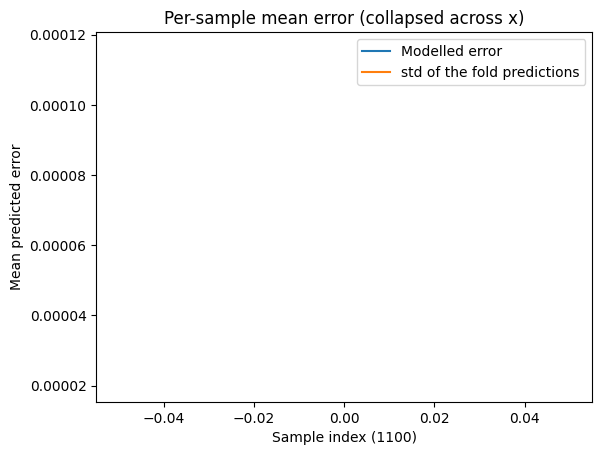

In [112]:
mean_err1 = model_error.mean(axis=1)
mean_err2 = fold_preds_std.mean(axis=1)

plt.plot(mean_err1, label="Modelled error")
plt.plot(mean_err2, label="std of the fold predictions")
plt.xlabel("Sample index (1100)")
plt.ylabel("Mean predicted error")
plt.title("Per-sample mean error (collapsed across x)")
plt.legend()
plt.show()

/tmp/ipykernel_24/560834762.py:2: RankWarning: Polyfit may be poorly conditioned
  m, c = np.polyfit(mean_err1[mask], mean_err2[mask], deg=1)


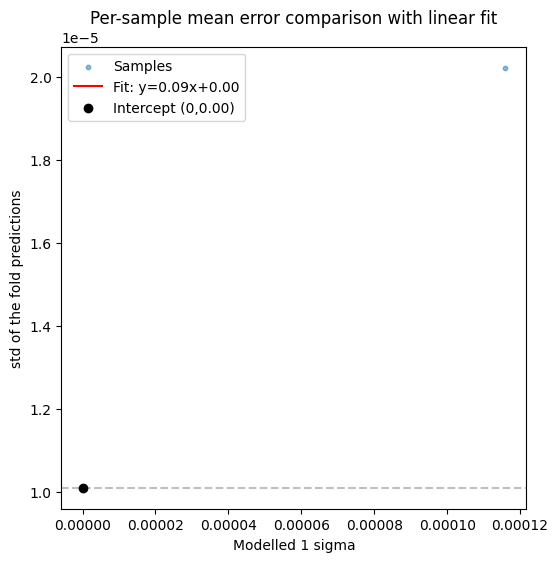

In [113]:
mask = mean_err1 <= WEIGHTED_ENSEMBLE_THRESHOLD
m, c = np.polyfit(mean_err1[mask], mean_err2[mask], deg=1)

plt.figure(figsize=(6,6))
plt.scatter(mean_err1, mean_err2, s=10, alpha=0.5, label="Samples")
x_vals = np.linspace(mean_err1.min(), mean_err1.max(), 200)
plt.plot(x_vals, m*x_vals + c, 'r-', label=f"Fit: y={m:.2f}x+{c:.2f}")
plt.scatter(0, c, color="black", zorder=5, label=f"Intercept (0,{c:.2f})")
plt.axhline(c, color="gray", linestyle="--", alpha=0.5)  # horizontal guide
plt.xlabel("Modelled 1 sigma")
plt.ylabel("std of the fold predictions")
plt.title("Per-sample mean error comparison with linear fit")
plt.legend()
plt.show()

So the rms error by fold is about one quarter of the modelled error predictions, and the relationship is correllated but not linear. Let's allow the hidden dataset to determine the relative size.    Let's compare these modelled predictions with the actual error.

In [114]:
train_labels = pd.read_csv(paths.train_csv, index_col="planet_id")
train_labels.head()

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
planet_id,,,,,,,,,,,,,,,,,,,,,
34983,0.018291,0.018088,0.018087,0.018085,0.018084,0.018084,0.018084,0.018084,0.018085,0.018084,...,0.018109,0.018112,0.018118,0.018123,0.018125,0.018127,0.018130,0.018134,0.018138,0.018142
1873185,0.006347,0.006343,0.006343,0.006343,0.006343,0.006343,0.006343,0.006342,0.006342,0.006341,...,0.006340,0.006340,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339
3849793,0.046061,0.046139,0.046130,0.046117,0.046107,0.046105,0.046109,0.046112,0.046111,0.046104,...,0.046144,0.046133,0.046131,0.046138,0.046141,0.046147,0.046147,0.046139,0.046134,0.046133
8456603,0.015363,0.015387,0.015385,0.015385,0.015385,0.015385,0.015384,0.015383,0.015383,0.015384,...,0.015471,0.015471,0.015467,0.015465,0.015465,0.015464,0.015461,0.015460,0.015460,0.015460
23615382,0.014474,0.014636,0.014628,0.014635,0.014643,0.014642,0.014637,0.014635,0.014639,0.014644,...,0.014473,0.014467,0.014433,0.014426,0.014435,0.014422,0.014399,0.014429,0.014444,0.014418


In [115]:
scale = 1 / m if len(star_info) > 1 else 4   #just fixing it to 4 to make parameter tuning easier
fold_preds_std = fold_preds_std * scale

In [116]:
fold_submissions = {}
for outer_fold in range(FOLDS):
    fold_submissions[f'fold_{outer_fold}'] = pd.concat([inner_predictions[outer_fold], fold_std[outer_fold]], axis=1)

## Ensemble

In [117]:
stacked = np.stack([df.values for df in inner_predictions.values()])
mean_array = stacked.mean(axis=0)
columns = [f'wl_{wl+1}' for wl in range(283)]
ensembled_preds_df = pd.DataFrame(mean_array.clip(0, None), index=star_info.index, columns=columns)
ensembled_preds_df.head(2)

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
planet_id,,,,,,,,,,,,,,,,,,,,,
1103775,0.015801,0.015828,0.015829,0.015829,0.015829,0.015829,0.015828,0.015828,0.015827,0.015826,...,0.015899,0.015898,0.015897,0.015896,0.015896,0.015895,0.015895,0.015895,0.015895,0.015895


Now let's find the average error by planet and compare that to the error models!

In [118]:
if not SUBMIT_TO_COMPETITION:
    rms_df = pd.DataFrame(
    np.sqrt(((ensembled_preds_df - train_labels)**2).mean(axis=1)),
    index=ensembled_preds_df.index,
    columns=["rms"]
    )
    rms_df['modelled'] = mean_err1
    rms_df['scaled_fold_std'] = mean_err2 / 4
    display(rms_df.head())

In [119]:
if not SUBMIT_TO_COMPETITION:
    plt.figure(figsize=(6,6))

    # Scatter both methods against truth
    plt.scatter(rms_df["rms"], rms_df["modelled"], 
                s=20, alpha=0.6, label="Modelled", color="tab:blue")
    plt.scatter(rms_df["rms"], rms_df["scaled_fold_std"], 
                s=20, alpha=0.6, label="Scaled fold std", color="tab:orange")
    
    # 1:1 line
    lims = [0, 0.0015]
    plt.plot(lims, lims, "k--", alpha=0.7, label="1:1 line")
    
    plt.xlabel("Ground truth (RMS)")
    plt.xlim(0,0.0015)
    plt.ylabel("Predicted value")
    plt.title("Comparison of prediction methods against ground truth")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

This gets to the heart of the problem.  The LGBM model under-estimates the error for the higher variance samples.  I wonder if a simpler linear model would be better for those?

In [120]:
w1 = MODEL_FOLD_VAR_ENSEMBLE_WEIGHTS
w2 = 1 - w1

ensembled_error = np.where(
    model_error > WEIGHTED_ENSEMBLE_THRESHOLD,
    np.sqrt(w1**2 * model_error**2 + w2**2 * fold_preds_std**2),
    model_error
    ) * ERROR_FACTOR + ERROR_OFFSET

In [121]:
sigma_cols = [f'sigma_{i+1}' for i in range(283)]
ensembled_error_df = pd.DataFrame(ensembled_error, index = star_info.index, columns = sigma_cols)
ensembled_error_df.iloc[:,:1] = ensembled_error_df.iloc[:,:1].clip(AIRS_MIN_SIGMA*2, AIRS_MAX_SIGMA*2)
ensembled_error_df.iloc[:,1:] = ensembled_error_df.iloc[:,1:].clip(AIRS_MIN_SIGMA, AIRS_MAX_SIGMA)
ensembled_error_df.head(2)

,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,sigma_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
1103775,0.000265,0.00014,0.00014,0.00014,0.00014,0.00014,0.00014,0.000139,0.000139,0.000139,...,0.000177,0.000178,0.000179,0.000179,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018


In [122]:
sub_df = pd.concat([ensembled_preds_df.clip(0,None), ensembled_error_df], axis=1)
sub_df.head(2)

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
1103775,0.015801,0.015828,0.015829,0.015829,0.015829,0.015829,0.015828,0.015828,0.015827,0.015826,...,0.000177,0.000178,0.000179,0.000179,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018


In [123]:
if not SUBMIT_TO_COMPETITION:
    plotter = PlanetPlotter(planet_ids,
                            all_signal,
                            all_wl_fits,  #These are the original fits of the mean signal used to create the baseline, and their b & c parameters in a dictionary
                            breakpoints,
                            edges,
                            poly_df,
                            sub_df,
                            targ_df,
                            extra_feats_df,
                            )
    plotter.plot_planet(1739553248)

In [124]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(1124834224)

In [125]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(2554928345)

In [126]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(t_y_range=0.002)  #will use any planet id

In [127]:
if not SUBMIT_TO_COMPETITION:
    random_baddie = random.choice([3608862334])
    plotter.plot_planet(random_baddie)

In [128]:
if not SUBMIT_TO_COMPETITION:
    random_baddie = random.choice([1665810843])
    plotter.plot_planet(random_baddie, t_y_range=0.02)

In [129]:
if not SUBMIT_TO_COMPETITION:
    random_baddie = random.choice([204264160, 1267010874, 1349926825, 1597331512, 2270815333, 2557736212, 3786449677, 2609891029, 1401409675])
    plotter.plot_planet(random_baddie, t_y_range=0.02)

In [130]:
!ls

__notebook__.ipynb  signal_v5.npy


In [131]:
def competition_score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    naive_mean: float,
    naive_sigma: float,
    sigma_true: float = 0.00001,
    row_id_column_name: str = "planet_id",
    return_worst: int | None = None,  # new: optionally return worst fitting ids
) -> float | tuple[float, pd.DataFrame]:
    """
    Modified version: returns worst fitting predictions if return_worst is set.
    """

    row_ids = solution[row_id_column_name].values  # keep before dropping
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError("Negative values in the submission")
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f"Submission column {col} must be a number")

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths * 2:
        raise ParticipantVisibleError("Wrong number of columns in the submission")

    y_pred = submission.iloc[:, :n_wavelengths].values
    sigma_pred = np.clip(
        submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None
    )
    y_true = solution.values

    # per-row log-likelihood (sum over wavelengths for each sample)
    row_gll = np.sum(
        scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred), axis=1
    )

    # overall scores
    GLL_pred = row_gll.sum()
    GLL_true = np.sum(
        scipy.stats.norm.logpdf(
            y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)
        )
    )
    GLL_mean = np.sum(
        scipy.stats.norm.logpdf(
            y_true,
            loc=naive_mean * np.ones_like(y_true),
            scale=naive_sigma * np.ones_like(y_true),
        )
    )

    score = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)

    if return_worst is not None:
        # Attach row_ids and sort by worst log-likelihood
        worst_df = pd.DataFrame({
            row_id_column_name: row_ids,
            "row_loglikelihood": row_gll
        }).sort_values("row_loglikelihood").head(return_worst)

        first_index = worst_df.index[0]
        #print(f'The worst planet is {first_index}')

        return score, worst_df

    return score, None

In [132]:
def get_metrics(all_labels, fold_predictions, fold_ids, plotter):
    worst_rows = {}
    scores = []
    for fold in fold_ids:
        labels = all_labels.copy().loc[fold_ids[fold]['test_ids']].reset_index()
        predictions = fold_predictions[f'fold_{fold}'].copy().loc[fold_ids[fold]['test_ids']].reset_index()

        gll_score, badies_df = competition_score(
            labels,
            predictions,
            naive_mean=all_labels.values.mean(),
            naive_sigma=all_labels.values.std(),
            return_worst=5
        )
        print(f"Estimated competition score for fold {fold}: {gll_score:.3f}")

        worst_planet= badies_df['planet_id'].iloc[0]
        worst_score= badies_df.iloc[0]['row_loglikelihood']
        print(f'The worst planet was {worst_planet} with a score of {worst_score:.0f}')
        plotter.plot_planet(planet_id = worst_planet)

        scores.append(gll_score)
        worst_rows[fold] = badies_df

    mean = np.mean(scores)
    sigma = np.std(scores, ddof=1)  # sample standard deviation
    mean_minus_sigma = mean - sigma

    print(f"\nMean: {mean:.3}, 1σ:{sigma:.3}, Mean - 1σ: {mean_minus_sigma:.3}")
    
    return worst_rows


if GET_METRICS:
    train_labels = pd.read_csv(paths.train_csv, index_col="planet_id")
    badies_df = get_metrics(train_labels, fold_submissions, fold_ids, plotter)
    

WITH FACTOR 5   MEAN - SIGMA = 0.39  
WITH FACTOR 10   MEAN - SIGMA = .385  
WITH FACTOR 5   MEAN - SIGMA = 0.392  

* Directly after bug fixes (fgs sigma factor 1):       Mean: 0.487  1σ: 0.0148  Mean - 1σ: 0.472  
* Error and FGS factors changed to 1.1, fgs 1.5:       Mean: 0.49,  1σ:0.00967, Mean - 1σ: 0.48
* Removed less relevent reatures:                      Mean: 0.487, 1σ:0.0113, Mean - 1σ: 0.476
* Set error factor to 1.4:                             Mean: 0.485, 1σ:0.0086, Mean - 1σ: 0.476
  
It seems to peak around 1.1

* Reduced   fgs_sigma factor to 1.2:                     Mean: 0.488, 1σ:0.012, Mean - 1σ: 0.476  
* Increased fgs_sigma factor to 1.8:                     Mean: 0.49, 1σ:0.00982, Mean - 1σ: 0.481  
* Increased fgs_sigma factor to 2:                       Mean: 0.49, 1σ:0.00982, Mean - 1σ: 0.481  


* Increased min_child_samples for error to 20          Mean: 0.487, 1σ:0.0122, Mean - 1σ: 0.475
* child-samples 8, num_leaves 10                       Mean: 0.489, 1σ:0.00996, Mean - 1σ: 0.479 
* child-samples 8, num_leaves 6                        Mean: 0.489, 1σ:0.0095, Mean - 1σ: 0.479

Tried increasing the kernel to 35 but no improvement
Tried using build_serial_tree but no improvement


Forced reflection in any case where left > right (removed breakpoint condition)
* Mean: 0.493, 1σ:0.00792, Mean - 1σ: 0.485


Added a darkening correction feature

* Original Mean: 0.494, 1σ:0.0078, Mean - 1σ: 0.486
* Corrected cos_i, extra features:                                  Mean: 0.502, 1σ:0.00918, Mean - 1σ: 0.493  #LB score 0.424
* Reduced error factor 1.1 to 1, and lower limit .00015 to .0001:   Mean: 0.499, 1σ:0.0102, Mean - 1σ: 0.488
* Put back error factor, but left the lower limit at .0001          Mean: 0.502, 1σ:0.0139, Mean - 1σ: 0.488
* Increased leaves from 10 to 12                                    Mean: 0.502, 1σ:0.0105, Mean - 1σ: 0.492   #LB score current best 0.426
* Removed the polynomeal dataframe from the features                Mean: 0.498, 1σ:0.0197, Mean - 1σ: 0.478
* Tried a variable conv kernel from 15 to 35                        Mean: 0.497, 1σ:0.017, Mean - 1σ: 0.48

* New scheme to fit the x0 and x2 to a straight line                Mean: 0.502, 1σ:0.0116, Mean - 1σ: 0.49
* Added edge detection                                              Mean: 0.507, 1σ:0.0134, Mean - 1σ: 0.494
* New features added (with over curve depth, egress/width)          Mean: 0.512, 1σ:0.0133, Mean - 1σ: 0.499
* Changed max right edges from (10 and 30) to 20,20                 Mean: 0.512, 1σ:0.0125, Mean - 1σ: 0.5
* Incresed the baseline number of samples from 5 per side to 10     Mean: 0.51, 1σ:0.0113, Mean - 1σ: 0.498
* Added a max_slope feature                                         Mean: 0.519, 1σ:0.0149, Mean - 1σ: 0.505
* Incresed number of leaves for the fit to 14                       Mean: 0.52, 1σ:0.0163, Mean - 1σ: 0.503
* New Localised features for the error                              Mean: 0.521, 1σ:0.00775, Mean - 1σ: 0.513
* Increased error model leaves and depth                            Mean: 0.521, 1σ:0.00782, Mean - 1σ: 0.513
* Submission with 10 folds                                          Mean: 0.522, 1σ:0.00842, Mean - 1σ: 0.513
* conv kernel: min 15, max 25                                       Mean: 0.513, 1σ:0.00603, Mean - 1σ: 0.507
* Changed so first fits use the max.  min 17, max 25                Mean: 0.518, 1σ:0.0115, Mean - 1σ: 0.506
* Constant kernel of 19                                             Mean: 0.516, 1σ:0.00937, Mean - 1σ: 0.506
* Switched to a gaussian weighted kernel width 25                   Mean: 0.521, 1σ:0.0059, Mean - 1σ: 0.516
* Gaussian Kernel for the bins                                      Mean: 0.508, 1σ:0.0175, Mean - 1σ: 0.49
* Reduced all kernels to 21                                         Mean: 0.51, 1σ:0.0061, Mean - 1σ: 0.504
* Increased all kerneld to 29                                       Mean: 0.512, 1σ:0.0146, Mean - 1σ: 0.498
* Kernels 25, top points 10, fixed bug with top_points?             Mean: 0.511, 1σ:0.00359, Mean - 1σ: 0.507
* Left_edge 10, right edge 30, top points 10                        Mean: 0.513, 1σ:0.00479, Mean - 1σ: 0.508
* Left_edge 10, right edge 50                                       Mean: 0.508, 1σ:0.00752, Mean - 1σ: 0.5
* Left_edge 2, right edge 40    Modified the gaussian edge case     Mean: 0.524, 1σ:0.00614, Mean - 1σ: 0.518
* Added localised second order differential mean and max            Mean: 0.519, 1σ:0.0168, Mean - 1σ: 0.502
* Introduced PCA and a threshold for interpolated fit of 0.002      Mean: 0.543, 1σ:0.00991, Mean - 1σ: 0.533
* Changed intperolated kernel to 17                                 Mean: 0.533, 1σ:0.0111, Mean - 1σ: 0.521
* interpolated fit of threshold 0.003  (put kernel back to 21)      Mean: 0.535, 1σ:0.0157, Mean - 1σ: 0.519
* Threshold back to 0.002, main fitting kernel to 27                Mean: 0.53, 1σ:0.00612, Mean - 1σ: 0.524
* Changed the polypoints range to ignore the fgs bin                Mean: 0.539, 1σ:0.0108, Mean - 1σ: 0.528
* Changed the interp threshold to .0015                             Mean: 0.532, 1σ:0.00714, Mean - 1σ: 0.525
* Changed the interp threshold to .0025                             Mean: 0.537, 1σ:0.0121, Mean - 1σ: 0.524



* Tentatively putting back the fgs score into the polypoints calculation, and the threshold back to 0.002.  Not convinced these last ethree experiments made any meaningful change.
* New pre-process with no hot-pixel mask                           Mean: 0.54, 1σ:0.00986, Mean - 1σ: 0.53
* Increase num_leaves to 13                                        Mean: 0.533, 1σ:0.0104, Mean - 1σ: 0.523
*  Changed to 11 leaves                                            Mean: 0.534, 1σ:0.00756, Mean - 1σ: 0.527
*  Added features, and put PCA back into error model               Mean: 0.538, 1σ:0.0089, Mean - 1σ: 0.53    New best LB score .472
*  Incresed to 14 fit points, reduced conv kernel to 19            Mean: 0.539, 1σ:0.0103, Mean - 1σ: 0.529
*  Back to 12 Bins, reduced conv kernel to 17                      Mean: 0.539, 1σ:0.0166, Mean - 1σ: 0.522
*  Increased min leaves to 15 for the fit                          Mean: 0.533, 1σ:0.00598, Mean - 1σ: 0.527
*  Added a *  w*2/width  and adjusted the limb darekening feature  Mean: 0.536, 1σ:0.0035, Mean - 1σ: 0.533
   With error factor 1.2                                           Mean: 0.538, 1σ:0.00909, Mean - 1σ: 0.529
*  With error factor 1.2, put back old limb darkening              Mean: 0.538, 1σ:0.0146, Mean - 1σ: 0.523
*  Error factor 1.2, new darkenging,removed the a * w*2/width term
*  Added a bunch of new features from the wavelength fits          Mean: 0.535, 1σ:0.00428, Mean - 1σ: 0.531
*  Fixed up bug in the crop_transitions                            Mean: 0.536, 1σ:0.00996, Mean - 1σ: 0.526   New best score 0.479
*  removed has_two_bps, transit_delta_height:                      Mean: 0.538, 1σ:0.0129, Mean - 1σ: 0.525
*  Added PCA fit features                                          Mean: 0.535, 1σ:0.0109, Mean - 1σ: 0.524
*  5 inner folds instead of 4                                      Mean: 0.537, 1σ:0.0108, Mean - 1σ: 0.526   New best score 0.482
*  Error feature from the variance and changed inner ensembling    Mean: 0.537, 1σ:0.0125, Mean - 1σ: 0.524
*  Added Batman fits and a bunch of other changes                  Mean: 0.526, 1σ:0.0161, Mean - 1σ: 0.51   New bast LB score 0.494

In [133]:
if GET_METRICS:
    display(badies_df[0])

In [134]:
if GET_METRICS:
    display(badies_df[1])

In [135]:
if GET_METRICS:
    display(badies_df[2])

In [136]:
if GET_METRICS:
    display(badies_df[4])

In [137]:
extra_feats_df[extra_feats_df['has_no_breakpoints'] == True]

,transit_width,max_wl_depth,mean_wl_depth,transit_residual_std,rel_noise,aspect,transit_fit_a,mean_depth,a,b,...,fgs_diff,a_w2_depth,polypoints_range,polypoints_std,polypoints_mean,original_fgs,mean_first_diff,mean_second_diff,first_second_std_sum,c_delta
planet_id,,,,,,,,,,,,,,,,,,,,,


In [138]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(158006264, t_y_range=0.02)

In [139]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(926530491, t_y_range=0.02)

In [140]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(1124834224, t_y_range=0.005)

In [141]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(1843015807, t_y_range=0.02)

In [142]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(2154305089, t_y_range=0.01)
    

In [143]:
if not SUBMIT_TO_COMPETITION:
    plotter.plot_planet(3649218579, t_y_range=0.01)

In [144]:
sub_df.to_csv('submission.csv')
check_df = pd.read_csv("submission.csv")
check_df.head(2)

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,1103775,0.015801,0.015828,0.015829,0.015829,0.015829,0.015829,0.015828,0.015828,0.015827,...,0.000177,0.000178,0.000179,0.000179,0.00018,0.00018,0.00018,0.00018,0.00018,0.00018
